In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# My libraries
import sys
sys.path.append('../')  

import models
import utils
import explainability_funct as ex

import math
import numpy as np
import pandas as pd
from collections import Counter

In [2]:
all_keys =  ['AMG', 'ATF', 'ATI', 'ATP', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Others',
        'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 'OTR', 'OXA', 'PAP',
        'PEN', 'POL', 'QUI', 'SUL', 'TTC',
        'MV hours', '# pat$_{atb}$', '# pat$_{MDR}$',
        'CAR$_{n}$', 'PAP$_{n}$', 'Others$_{n}$',
        'QUI$_{n}$', 'ATF$_{n}$', 'OXA$_{n}$', 'PEN$_{n}$',
        'CF3$_{n}$', 'GLI$_{n}$', 'CF4$_{n}$', 'SUL$_{n}$',
        'NTI$_{n}$', 'LIN$_{n}$', 'AMG$_{n}$', 'MAC$_{n}$',
        'CF1$_{n}$', 'GCC$_{n}$', 'POL$_{n}$', 'ATI$_{n}$',
        'MON$_{n}$', 'LIP$_{n}$', 'TTC$_{n}$', 'OTR$_{n}$',
        'CF2$_{n}$', 'ATP$_{n}$', 
        '# pat$_{tot}$',
        'Post change',
        'Insulin', 'Art nutrition', 'Sedation', 'Relax', 'Hepatic$_{fail}$',
        'Renal$_{fail}$', 'Coagulation$_{fail}$', 'Hemodynamic$_{fail}$',
        'Respiratory$_{fail}$', 'Multiorganic$_{fail}$',  '# transfusions',
        'Vasoactive drug', 'Dosis nems', 'Tracheo$_{hours}$', 'Ulcer$_{hours}$',
        'Hemo$_{hours}$', 'C01 PICC 1',
        'C01 PICC 2', 'C02 CVC - RJ',
        'C02 CVC - RS', 'C02 CVC - LS', 'C02 CVC - RF',
        'C02 CVC - LJ', 'C02 CVC - LF', '# catheters']

## Step 0. Run model

#### Parameters to be set

In [3]:
folders = ["s1", "s2", "s3"]
norm = "robustNorm"
device = torch.device('cuda:1')

way_to_build_graph = "dtw-hgd"
# Others ways: correlations; smoothness
typeOfGraph = "SpaceTimeGraph"
# Others ways: ProdGraph
path_A = typeOfGraph+"_Xtr_"+norm+"_th_0.975.csv"

T = 14
F = len(all_keys)

#### Model

In [4]:
# Always the same values, do not touch. 
in_dim_GCN = 1
out_dim_GCN = 1

# number of max epochs 
n_epochs = 1000

early_stopping_patience = 50

# Hyperparameters to be optimized (change this values)
h_dropout = [0.0, 0.15, 0.3]
h_learning_rate = [1e-3, 1e-2, 5e-2, 0.1]
h_decay = [0, 1e-5, 1e-4, 1e-3, 1e-2]
h_hid_lay = [4, 8, 16, 32, 64]
h_layers = [1, 2, 3, 4, 5, 6]
seed = [42, 76, 124, 163, 192, 205, 221, 245, 293]

fc_layer = [[1120, out_dim_GCN]]

# Parameters to define type of GCNN and type of output.
typeGCN = "higher_order_polynomial_gcnn"
K = [2,3]


params = {# Hyperparameters
         'h_layers':h_layers, 'n_epochs':n_epochs, 
          'h_dropout': h_dropout, 'h_learning_rate': h_learning_rate, 
          'h_decay':h_decay, 'h_hid_lay': h_hid_lay, 'K':K,
          'fc_layer': fc_layer,
          # seed to set initialization hyperparameters
          'seed': seed, 
          # Type of output GCN
          'typeGCN': typeGCN,
          # Dimensions of GCN (input/output)
          'in_dim_GCN': in_dim_GCN, 'out_dim_GCN': out_dim_GCN,
          # Patiente
          'early_stopping_patience':early_stopping_patience}

In [5]:
best_result_by_split = utils.loadBestHyperparameters("../hyperparameters/"+way_to_build_graph+"/#E5.1-SpaceGraph_th_0.975.json")
results, importance_nodes, fc_classifiers, gnn_models = utils.val_model(best_result_by_split, typeOfGraph, params, folders, norm, device, path_A, way_to_build_graph)

# Analysis of type of GNN
utils.typeOfGNN(folders, K, best_result_by_split, importance_nodes)

Early stopping at epoch 69
Early stopping at epoch 208
Early stopping at epoch 148
Low Pass Filter. # of filters: 2
Low Pass Filter. # of filters: 3
Low Pass Filter. # of filters: 3


* When I have variables named AMR or non-AMR it is equivalent in coding terms to MDR or non-MDR. 

# ANALYSIS A

# Computing the value of w⊤ * h(L) in Eq: (15)

In [6]:
h, w = importance_nodes[1][0], importance_nodes[2][0]
w = w.expand(350, 1120, 1)
result_wh = w * h 
result_wh.shape

torch.Size([350, 1120, 1])

## 1. REAL DATA

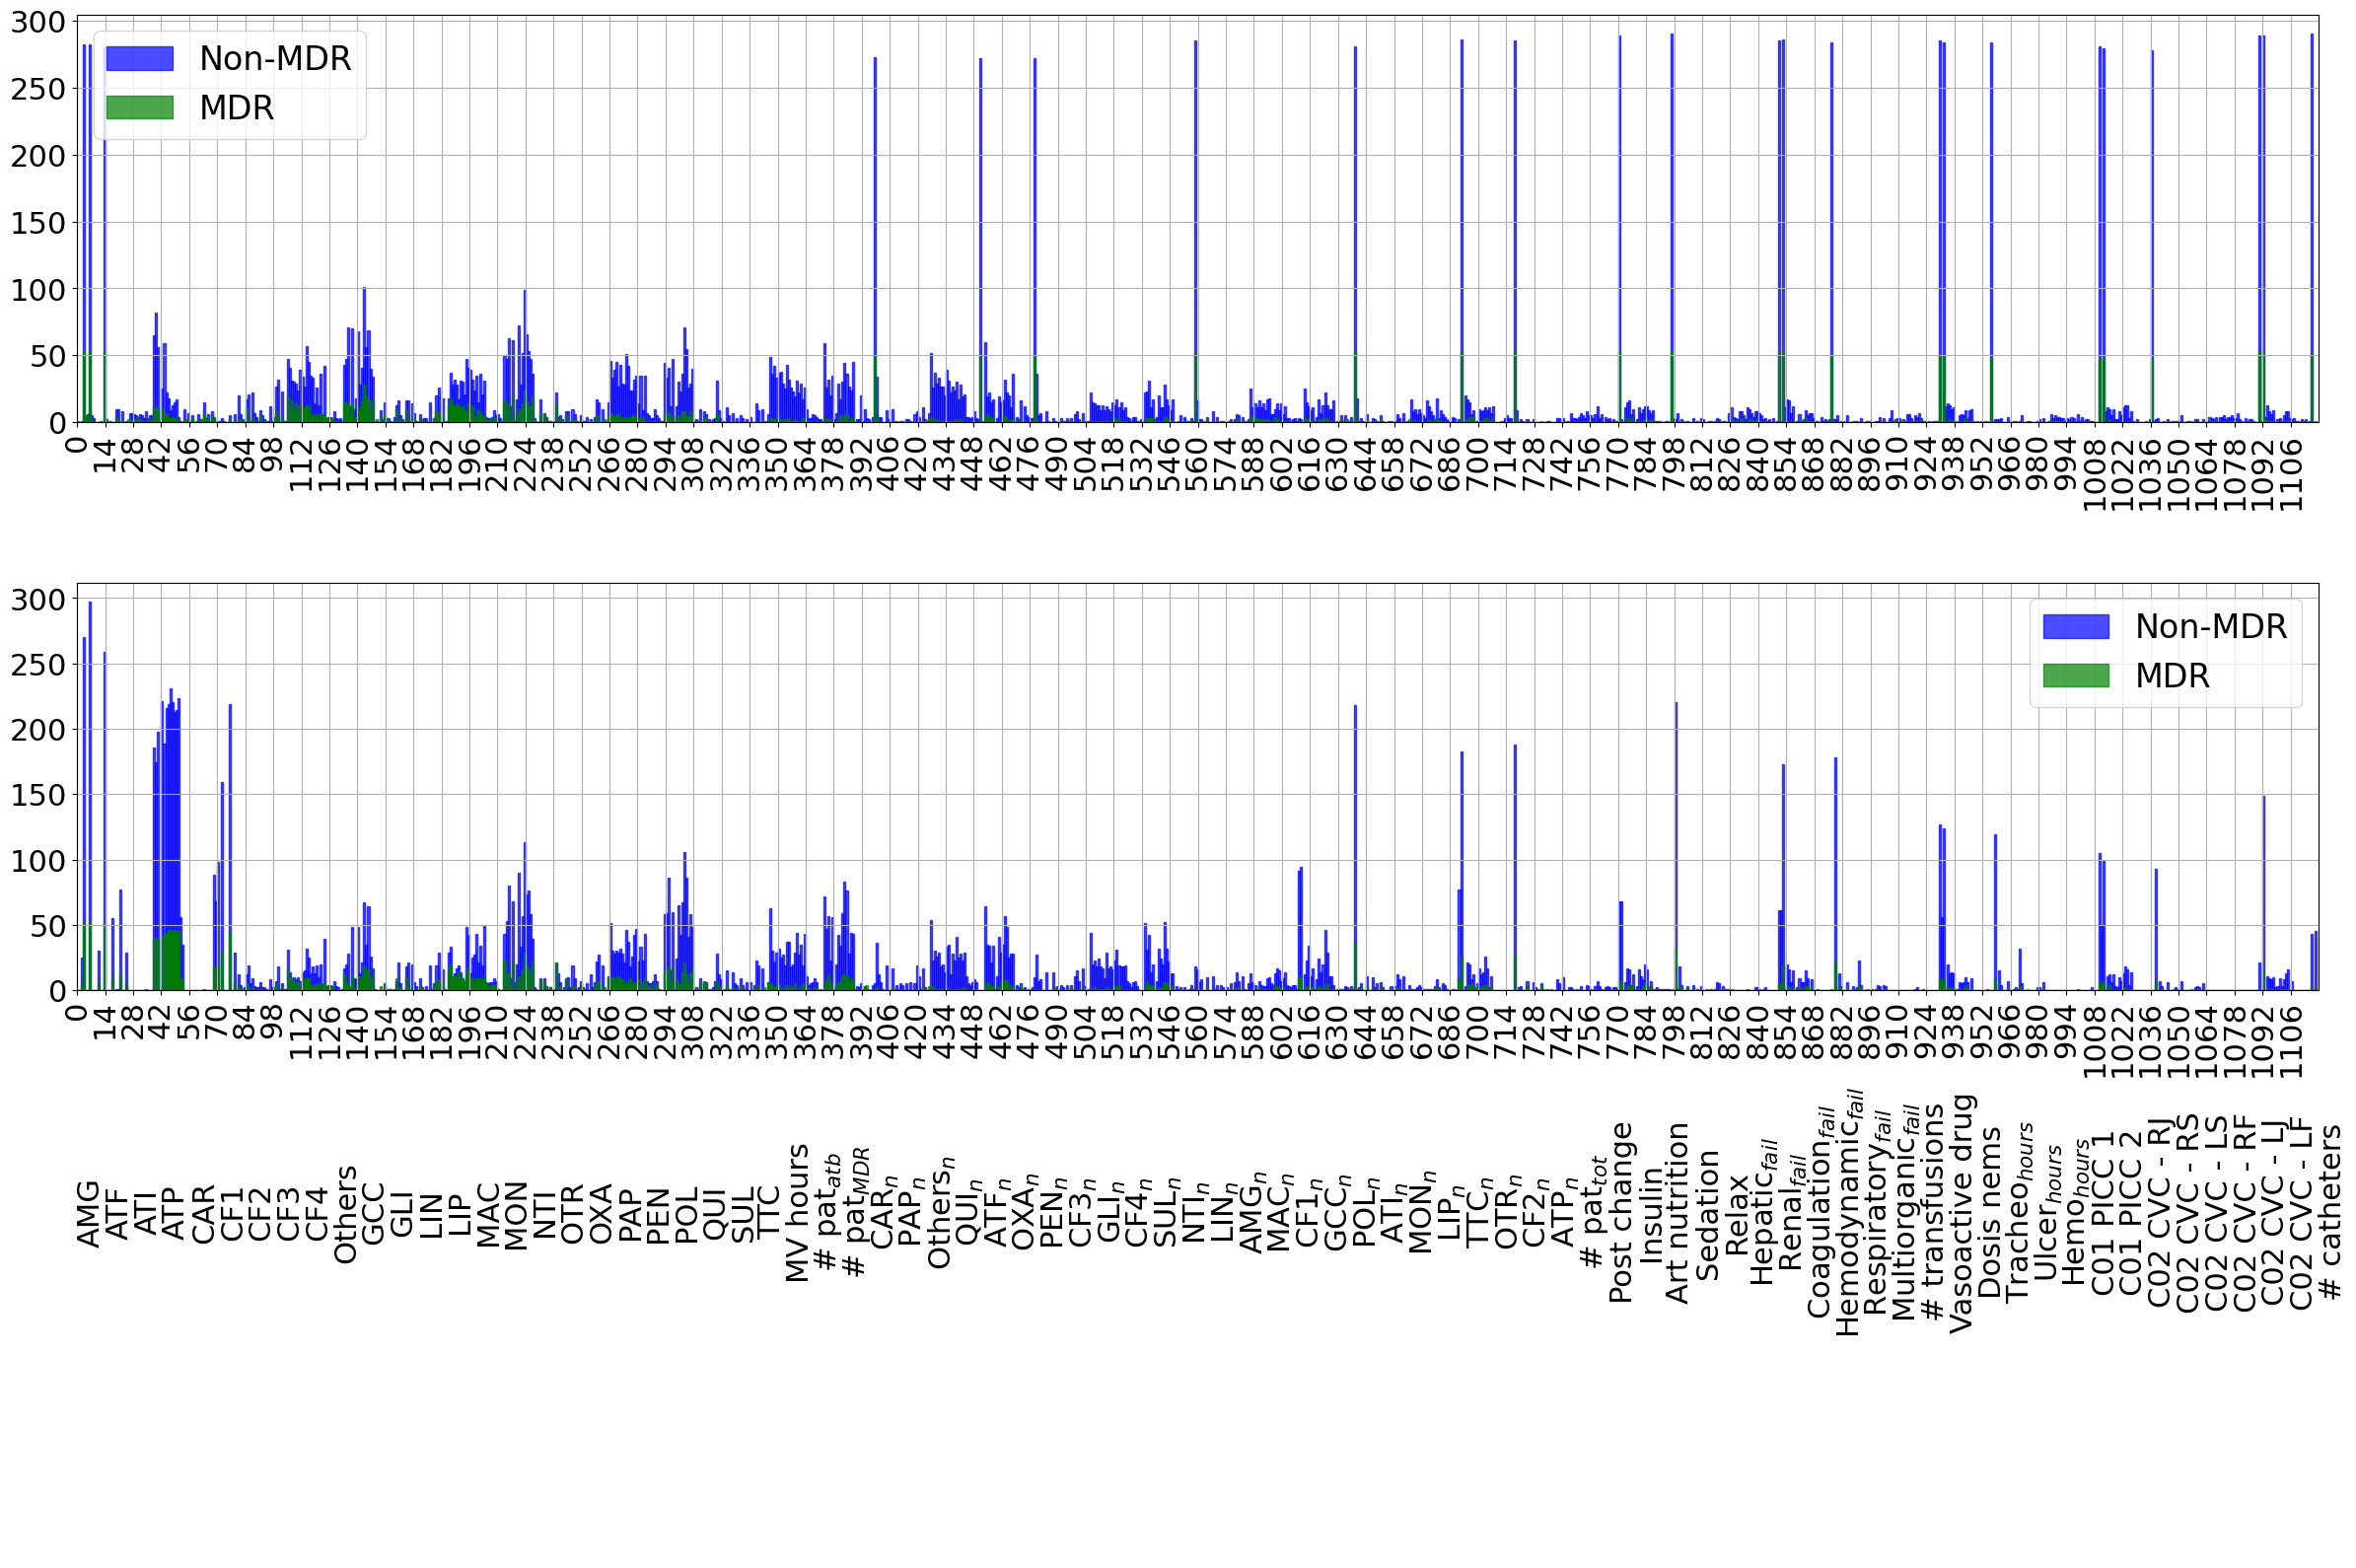

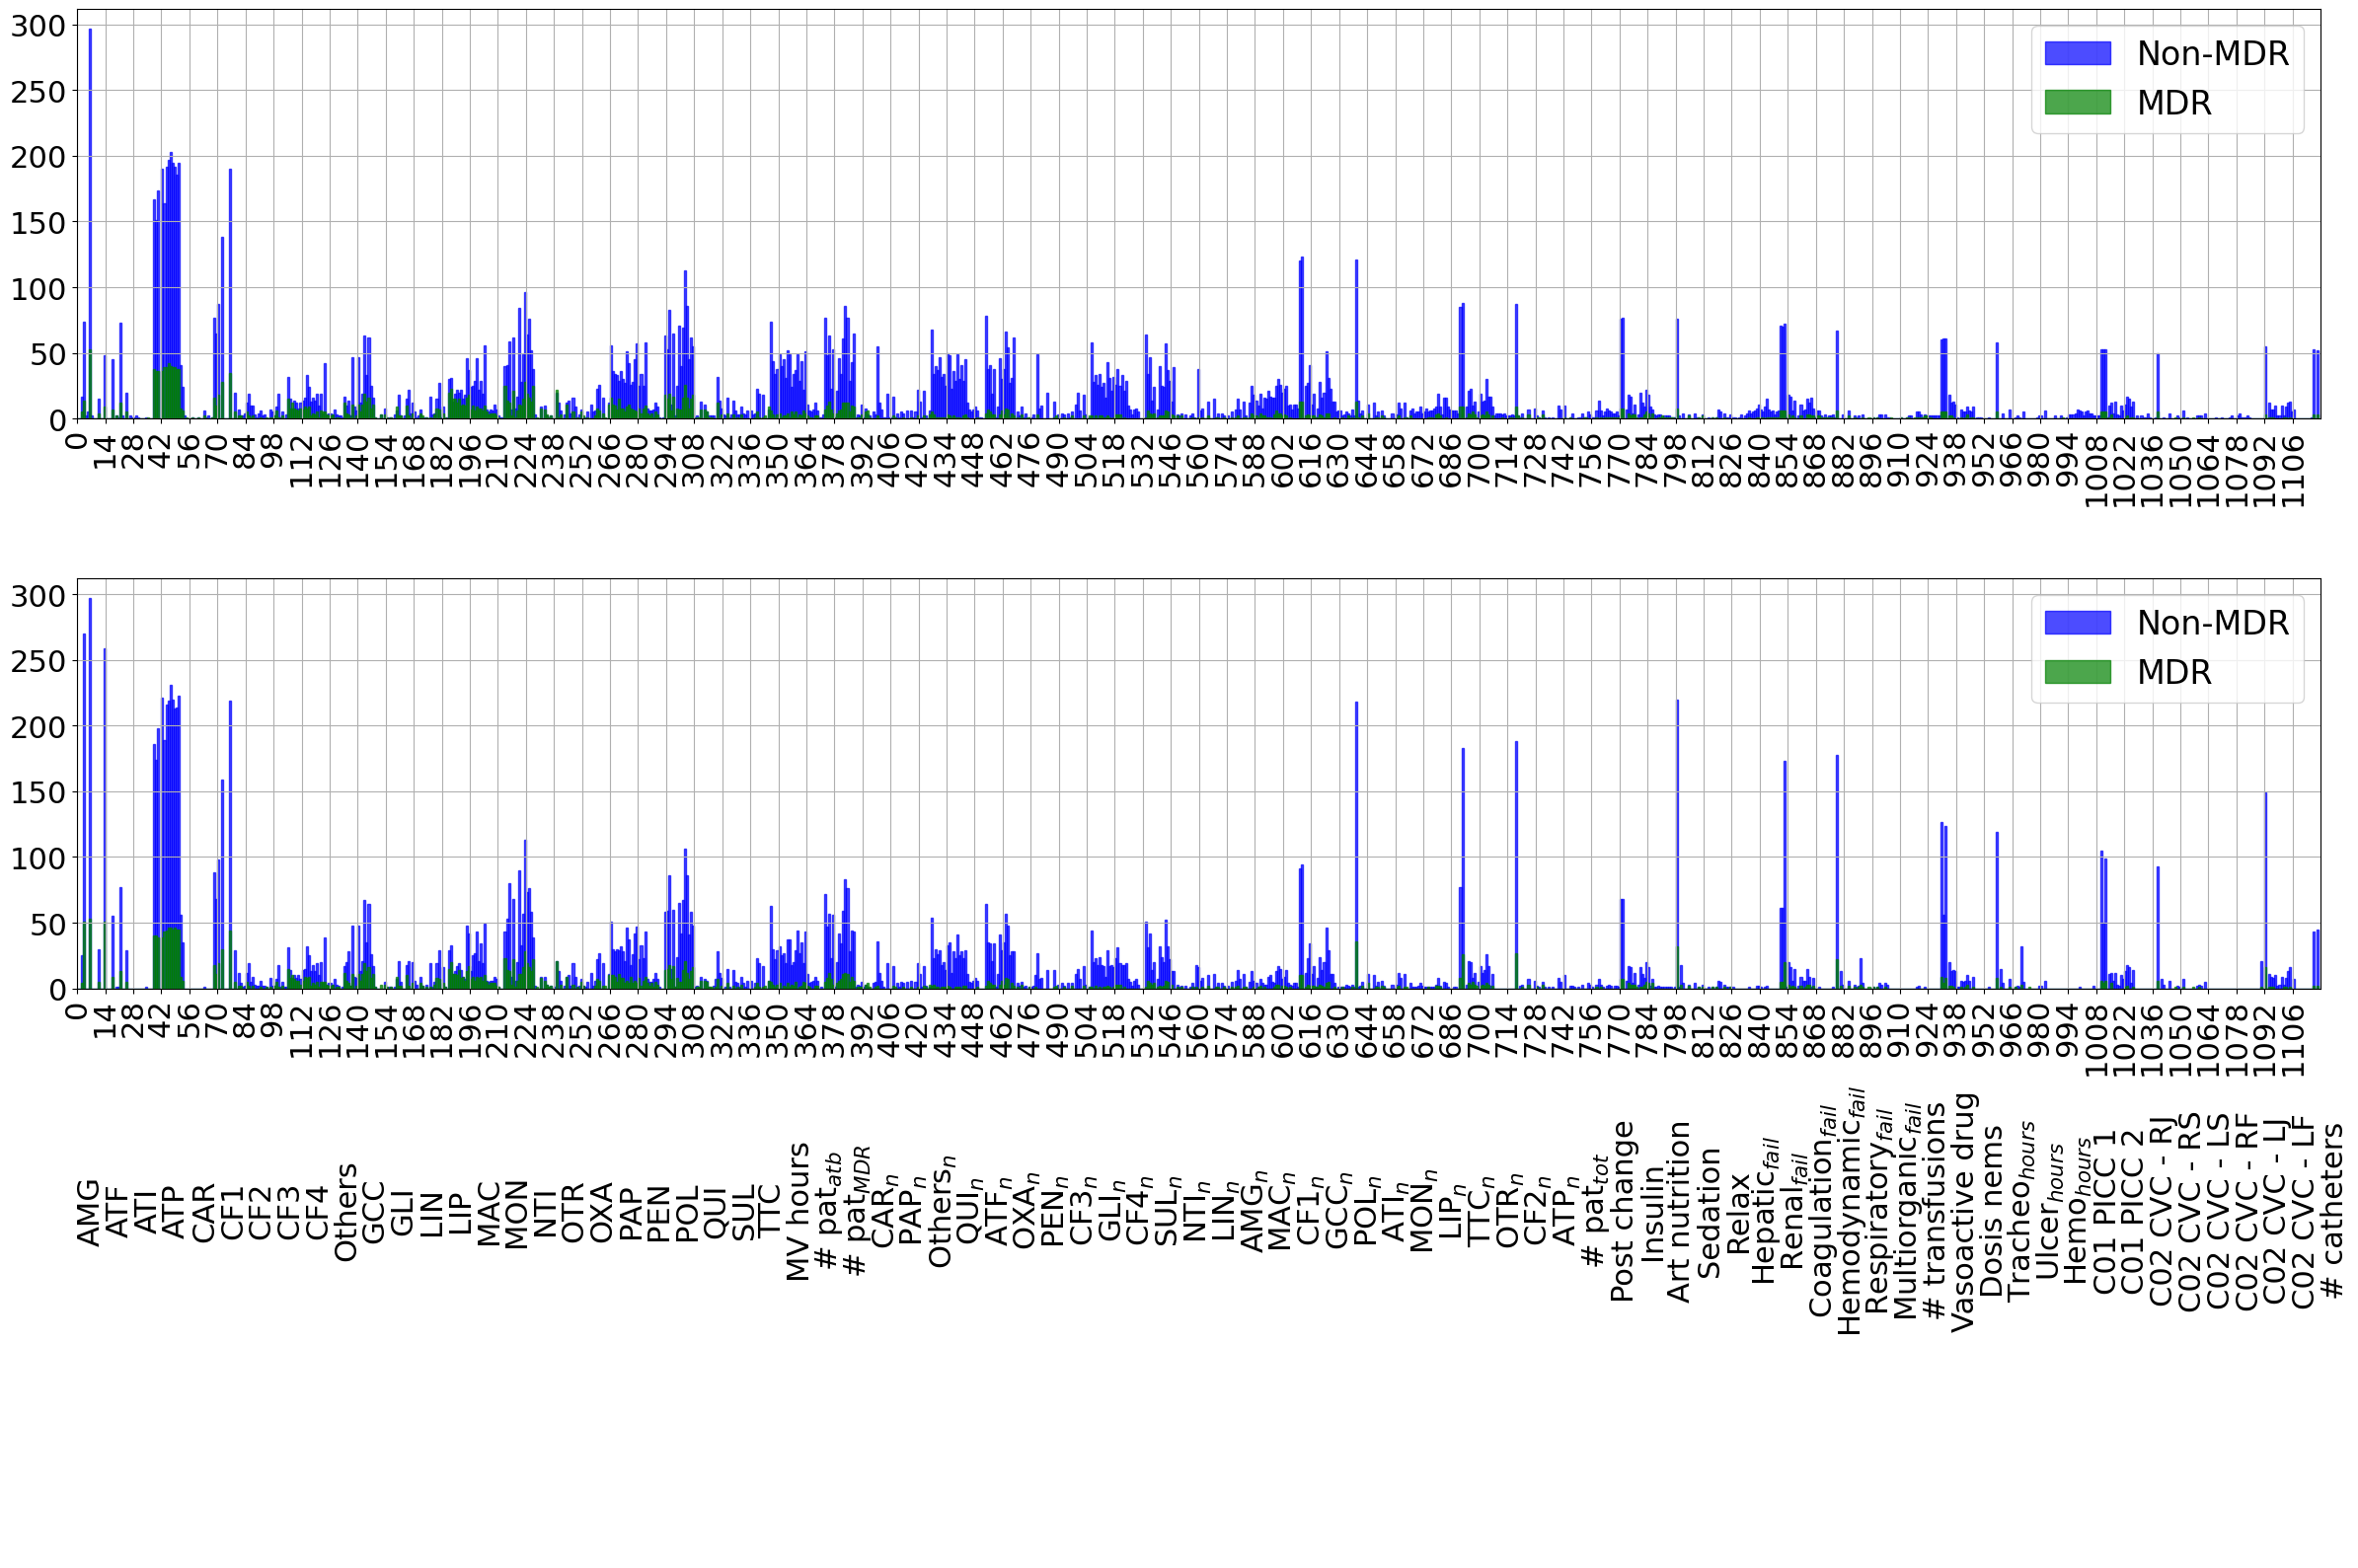

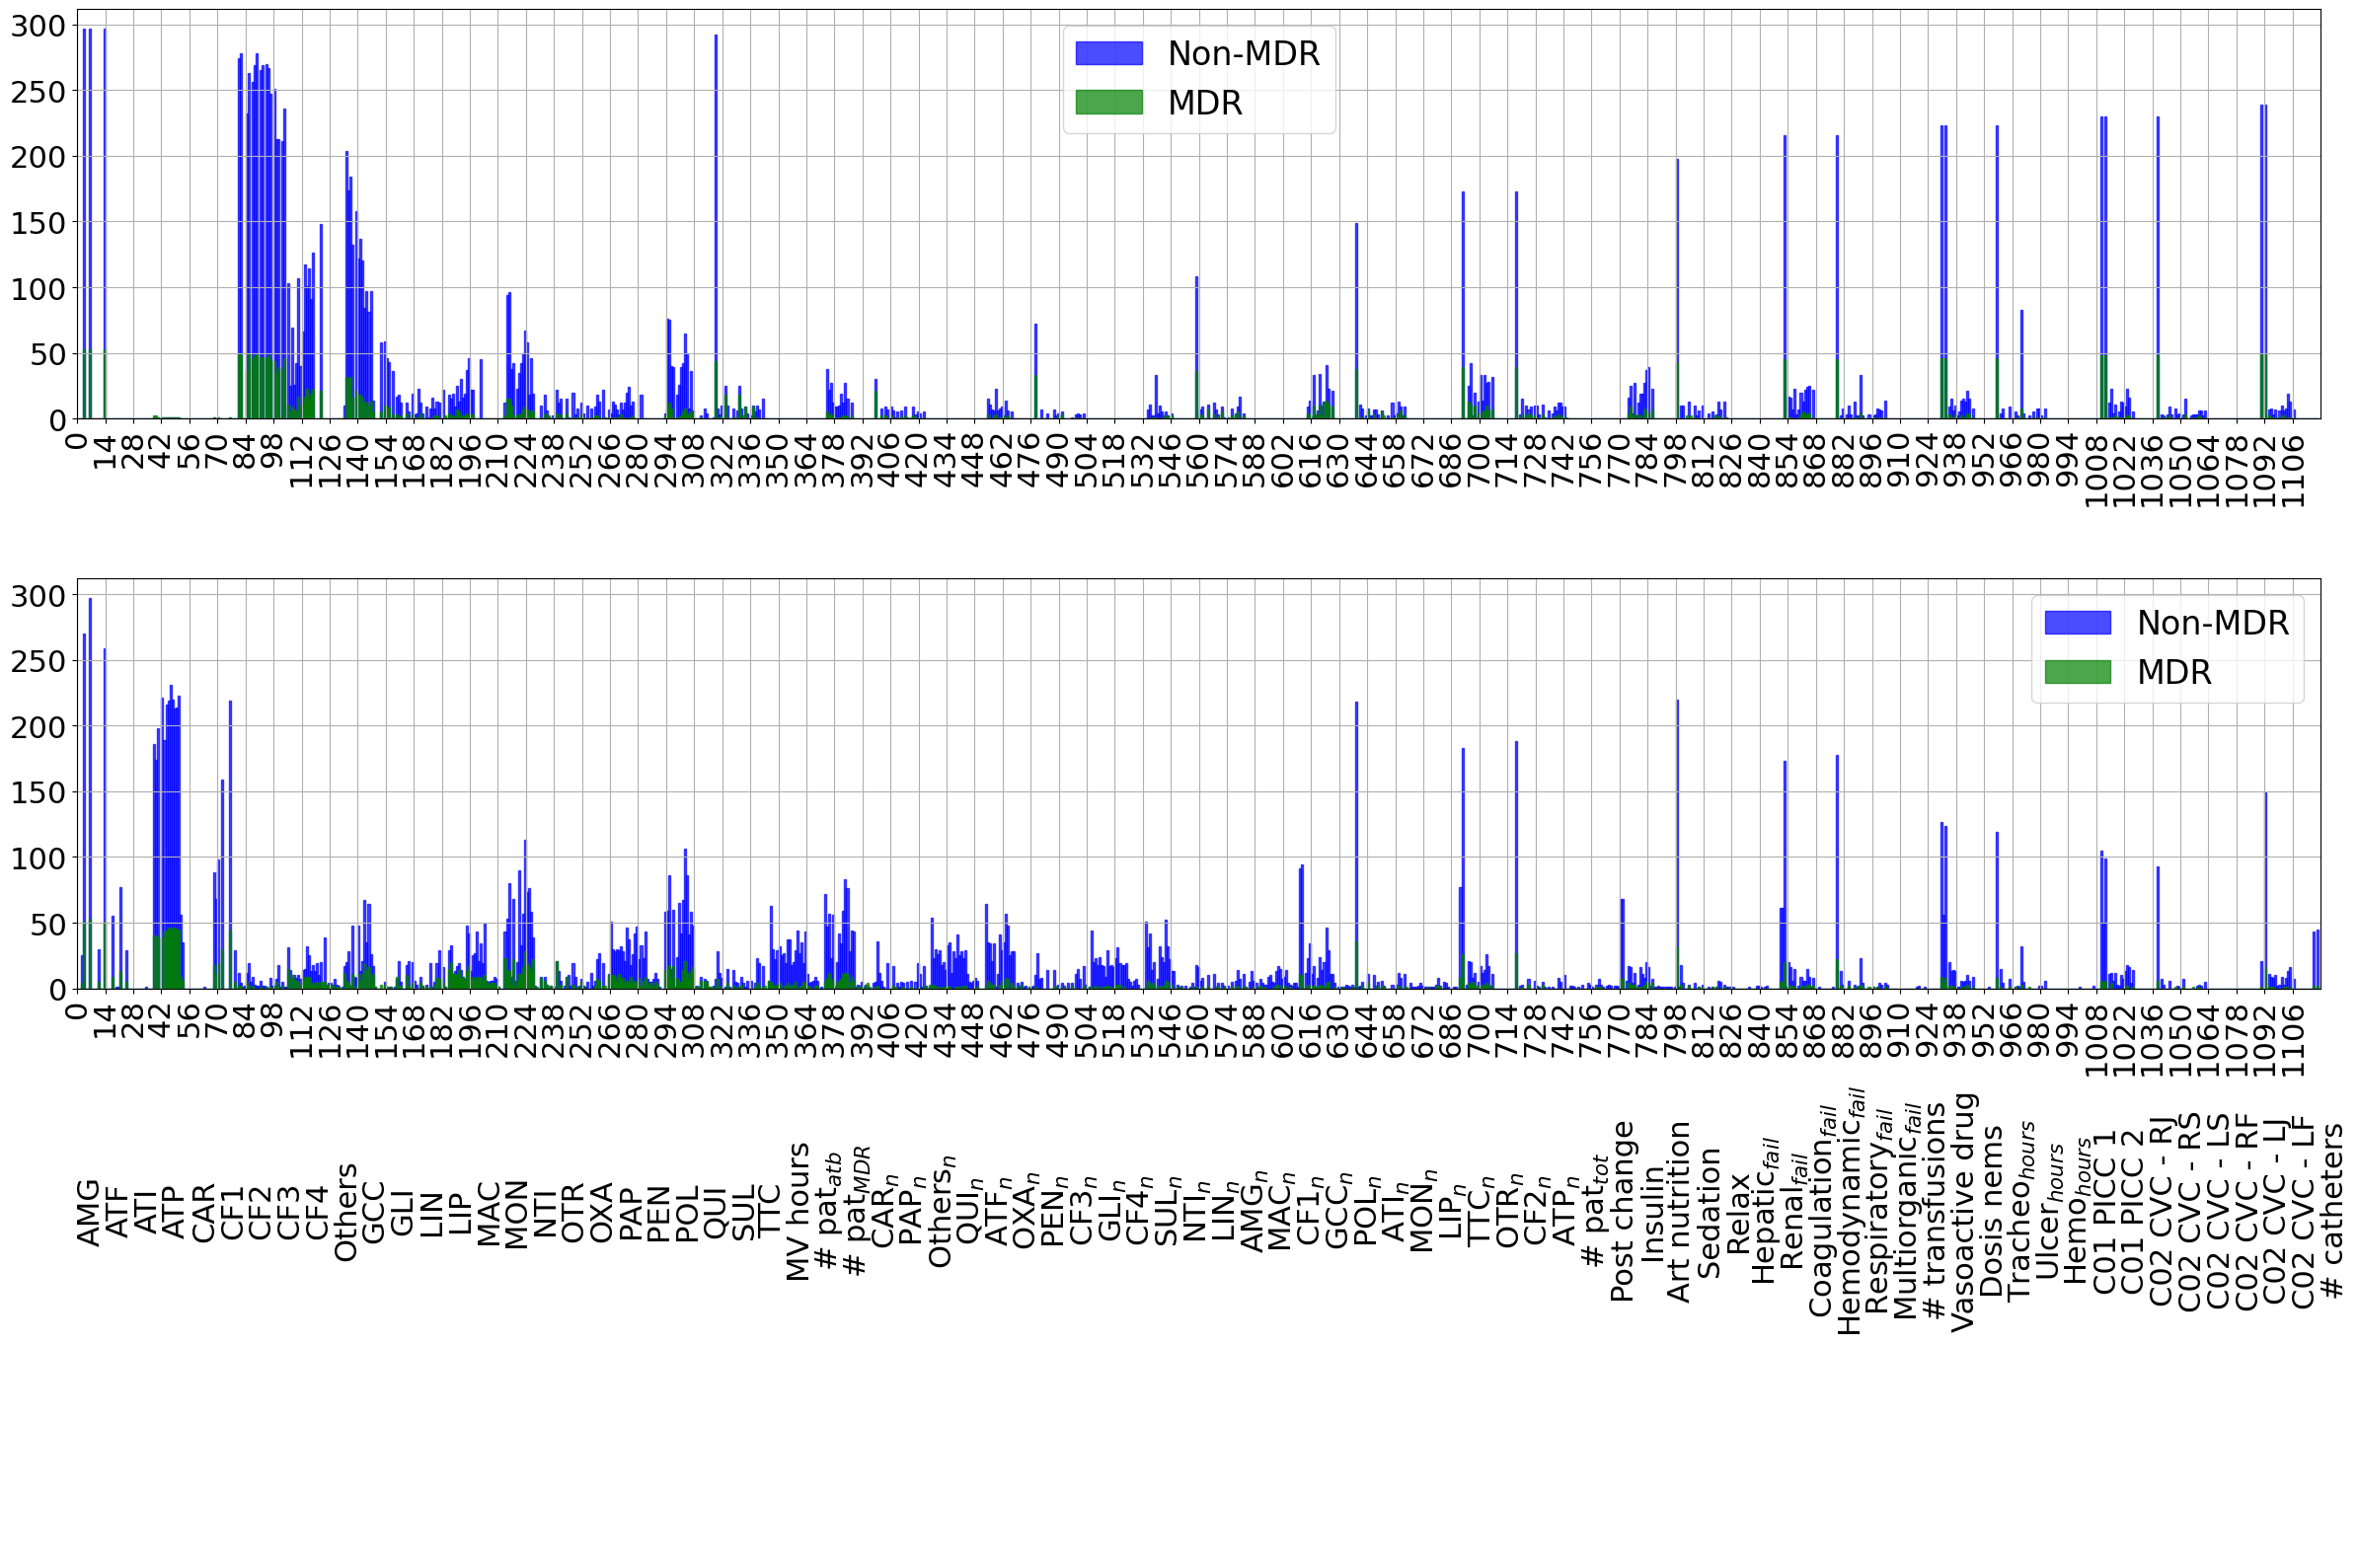

In [7]:
colors = ['blue', 'green']
topk_indices_count = 56
T = 14
F = 80
numberOfTimeStep = T

for c in range(len(folders)):
    
    # Lists to store the indexes of the 10 largest values in the second dimension for each first dimension
    indices_list_class_0 = []
    indices_list_class_1 = []
    indices_list_class_0_wh = []
    indices_list_class_1_wh = []

    split = folders[c]
    y_test = pd.read_csv("../../../DATA/" + split + "/y_test_"+norm+".csv")[['individualMRGerm_stac']]
    y_test = y_test.iloc[0:y_test.shape[0]:numberOfTimeStep].reset_index(drop=True)

    # Iterate on the first dimension (patients)
    for i in range(importance_nodes[c][0].size(0)):
        # Obtain the tensor corresponding to the first dimension
        tensor_slice = importance_nodes[c][0][i, :, :]
        class_label = y_test.iloc[i]['individualMRGerm_stac']  # Patient class

        # Obtain the indices of the 10 largest values in the second dimension
        topk_values, topk_indices = torch.topk(tensor_slice.squeeze().abs(), k=topk_indices_count)
        topk_values_wh, topk_indices_wh = torch.topk(result_wh[i].squeeze().abs(), k=topk_indices_count)

        # Add indexes to the list corresponding to the patient's class
        if class_label == 0:
            indices_list_class_0.extend(topk_indices.tolist())
            indices_list_class_0_wh.extend(topk_indices_wh.tolist())
        elif class_label == 1:
            indices_list_class_1.extend(topk_indices.tolist())
            indices_list_class_1_wh.extend(topk_indices_wh.tolist())

        
    
    # Plot histogram
    plt.figure(figsize=(24, 16))

    plt.subplot(3, 1, 1)
    plt.hist(indices_list_class_0, bins=range(T*F), edgecolor=colors[0], alpha=0.7, color=colors[0], label='Non-MDR')
    plt.hist(indices_list_class_1, bins=range(T*F), edgecolor=colors[1], alpha=0.7, color=colors[1], label='MDR')
    amr_pat = y_test[y_test.individualMRGerm_stac == 1].shape[0]
    nonamr_pat = y_test[y_test.individualMRGerm_stac == 0].shape[0]
    plt.grid(True)
    plt.xticks(range(0, T*F, T), rotation=90, fontsize=22)  # Fixed the range to exclude last T
    plt.yticks(fontsize=22)
    plt.xlim(0, T*F)
    plt.legend(fontsize=24)
    plt.tight_layout()
    
    plt.subplot(3, 1, 2)
    plt.hist(indices_list_class_0_wh, bins=range(T*F), edgecolor=colors[0], alpha=0.7, color=colors[0], label='Non-MDR')
    plt.hist(indices_list_class_1_wh, bins=range(T*F), edgecolor=colors[1], alpha=0.7, color=colors[1], label='MDR')
    plt.grid(True)
    plt.xticks(range(0, T*F, T), rotation=90, fontsize=22)  # Fixed the range to exclude last T
    plt.yticks(fontsize=22)
    plt.xlim(0, T*F)
    plt.legend(fontsize=24)
    plt.tight_layout()

    # Create a subplot for text with vertical grid lines
    ax = plt.subplot(3, 1, 3)
    ax.set_xlim(0, T*F)
    ax.set_ylim(0, 1)
    ax.set_xticks(range(0, T*F, T))  # Fixed the range to exclude last T
    ax.set_xticklabels(all_keys, rotation=90, fontsize=22)
    ax.set_yticks([])  # Hide y-axis ticks

    ax.axis('off')  # Hide the axis

    # Calculate appropriate x positions for text based on the number of features
    x_positions = np.linspace(0, T*F, len(all_keys)) + (T / 2)

    for i, (x, feature_name) in enumerate(zip(x_positions, all_keys)):
        ax.text(x, 0.85, feature_name, ha='center', va='center', rotation=90, fontsize=22)

    plt.tight_layout()

    # Save the figure as a PDF without margins
    plt.savefig(f"../Interpretability/"+way_to_build_graph+"/RD_E5STG_"+folders[c]+".pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

## A.1. Analysis of the Importance of Input Nodes - Real Values

In [8]:
f = 2
split = folders[f]
X_test = np.load("../../../DATA/" + split + "/X_test_tensor_" + norm + ".npy")
X_test[X_test == 666] = 0  # Replace placeholder values (666) with 0
n, dim1, dim2 = X_test.shape
X_test_vec = torch.tensor(X_test.reshape((n, dim1 * dim2)), dtype=torch.float32)

y_test = pd.read_csv("../../../DATA/" + split + "/y_test_" + norm + ".csv")[['individualMRGerm_stac']]
y_test = y_test.iloc[0:y_test.shape[0]:numberOfTimeStep].reset_index(drop=True)

pat_noAMR = list(y_test[y_test.individualMRGerm_stac == 0].index)
pat_noAMR_values = X_test_vec[pat_noAMR]
pat_noAMR_values_sum = torch.sum(pat_noAMR_values, dim=0)
result_noAMR = pat_noAMR_values_sum / pat_noAMR_values.size(0)

# Get the indices of the top 56 values in the second dimension
_, topk_indices_noAMR = torch.topk(result_noAMR.squeeze(), k=topk_indices_count)

pat_AMR = list(y_test[y_test.individualMRGerm_stac == 1].index)
pat_AMR_values = X_test_vec[pat_AMR]
pat_AMR_values_sum = torch.sum(pat_AMR_values, dim=0)
result_AMR = pat_AMR_values_sum / pat_AMR_values.size(0)
_, topk_indices_AMR = torch.topk(result_AMR.squeeze(), k=topk_indices_count)

## no-MDR

In [9]:
# Generate node names
node_names = ex.nodeNames()
idxs = list(set(topk_indices_noAMR))  # Remove duplicates and convert indices to a list
importantsNodes_noAMR_pre = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantsNodes_noAMR_pre))  # Output the count of important nodes-TS
result = ex.splitListElements(importantsNodes_noAMR_pre)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

Number of selected nodes-TS: 56


,0,1,2,3,4,5
# catheters,X,X,X,X,-,-
# pat$_{MDR}$,X,X,X,-,-,-
# pat$_{atb}$,X,X,X,X,X,-
# pat$_{tot}$,X,X,X,X,X,X
ATF$_{n}$,X,X,-,-,-,-
CAR$_{n}$,X,X,X,X,-,-
CF3$_{n}$,-,-,X,-,-,-
Dosis nems,X,X,X,X,X,-
Hemodynamic$_{fail}$,-,X,X,-,-,-
Insulin,-,X,X,-,-,-


## MDR

In [10]:
idxs = list(set(topk_indices_AMR))  # Remove duplicates and convert indices to a list
importantsNodes_AMR_pre = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantsNodes_AMR_pre))  # Output the count of important nodes-TS
result = ex.splitListElements(importantsNodes_AMR_pre)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table # Display the table

Number of selected nodes-TS: 56


,0,1,2,3
# catheters,X,X,-,-
# pat$_{MDR}$,X,X,-,-
# pat$_{atb}$,X,X,X,-
# pat$_{tot}$,X,X,X,X
# transfusions,X,-,-,-
ATF$_{n}$,X,X,-,-
CAR,X,X,-,-
CAR$_{n}$,X,X,X,-
CF3$_{n}$,X,X,-,-
Coagulation$_{fail}$,X,-,-,-


## MDR vs nonMDR

In [11]:
## Nodes that differ between MDR and non-MDR class
unique_variables = ex.uniqueVariablesInSecondList(importantsNodes_noAMR_pre, importantsNodes_AMR_pre)
result = ex.splitListElements(unique_variables)
table = ex.createTableWithSymbols(result)
table

,0,1,2
# transfusions,X,-,-
CAR,X,X,-
CF3$_{n}$,X,X,-
Coagulation$_{fail}$,X,-,-
GLI$_{n}$,-,X,-
Hemodynamic$_{fail}$,X,-,-
MV hours,X,-,-
Others$_{n}$,-,-,X
Post change,-,X,-
Sedation,X,X,-


## A.2. Analysis of the Importance of Output Nodes

In [12]:
pat_noAMR = list(y_test[y_test.individualMRGerm_stac == 0].index)
pat_AMR = list(y_test[y_test.individualMRGerm_stac == 1].index)

# importance_features_nonMDR = result_wh[pat_noAMR]
importance_features_nonMDR = importance_nodes[f][0][pat_noAMR]

# importance_features_MDR =  result_wh[pat_AMR]
importance_features_MDR = importance_nodes[0][0][pat_AMR]

pat_noAMR_values = importance_features_nonMDR
pat_noAMR_values_sum = torch.sum(pat_noAMR_values, dim=0)
result_noAMR = pat_noAMR_values_sum / pat_noAMR_values.size(0)

 # Get the indices of the 10 largest values in the second dimension
_, topk_indices_noAMR = torch.topk(result_noAMR.squeeze(), k=topk_indices_count)
        

pat_AMR_values = importance_features_MDR
pat_AMR_values_sum = torch.sum(pat_AMR_values, dim=0)
result_AMR = pat_AMR_values_sum / pat_AMR_values.size(0)
_, topk_indices_AMR = torch.topk(result_AMR.squeeze(), k=topk_indices_count)

### no-MDR

In [13]:
idxs = list(set(topk_indices_noAMR))  # Remove duplicates and convert indices to a list
importantsNodes_noAMR_pre = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantsNodes_noAMR_pre))  # Output the count of important nodes-TS
result = ex.splitListElements(importantsNodes_noAMR_pre)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

Number of selected nodes-TS: 56


,0,1,2,3
# pat$_{MDR}$,-,-,-,X
# pat$_{atb}$,-,X,X,X
# pat$_{tot}$,-,X,X,X
# transfusions,-,-,-,X
AMG$_{n}$,-,-,-,X
ATI,X,-,-,-
ATI$_{n}$,X,-,-,-
ATP,X,-,-,-
ATP$_{n}$,X,-,-,-
C01 PICC 1,-,-,-,X


### MDR

In [14]:
idxs = list(set(topk_indices_AMR))  # Remove duplicates and convert indices to a list
importantsNodes_AMR_pre = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantsNodes_AMR_pre))  # Output the count of important nodes-TS
result = ex.splitListElements(importantsNodes_AMR_pre)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table # Display the table

Number of selected nodes-TS: 56


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{MDR}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# transfusions,-,-,X,-,-,-,-,-,-,-,-,-,-,-
ATF$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATI,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATI$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,X,X,X
C02 CVC - LF,-,-,-,-,X,X,X,X,X,-,-,-,-,-


In [15]:
## Nodes that differ between MDR and non-MDR class
unique_variables = ex.uniqueVariablesInSecondList(importantsNodes_noAMR_pre, importantsNodes_AMR_pre)
result = ex.splitListElements(unique_variables)
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{MDR}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
# transfusions,-,-,X,-,-,-,-,-,-,-,-,-,-,-
ATF$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,X,X,X
C02 CVC - LF,-,-,-,-,X,X,X,X,X,-,-,-,-,-
C02 CVC - RF,-,-,-,-,-,-,-,-,-,X,X,X,X,X
CAR$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-


## 1.2.1. More information. Other analysis

### Most relevant variables for MDR patients

In [16]:
# Extract the selected nodes for MDR patients
idxs = list(set(indices_list_class_1))  # Remove duplicates and convert indices to a list
importantNodes_AMR = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantNodes_AMR))  # Output the count of important nodes-TS
result = ex.splitListElements(importantNodes_AMR)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

Number of selected nodes-TS: 350


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# pat$_{MDR}$,-,X,X,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# transfusions,-,X,X,X,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUL$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
Sedation,-,X,X,X,X,X,X,X,X,X,-,X,X,-
TTC$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
Tracheo$_{hours}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-


In [17]:
occurrences = ex.countIndexOccurrences(indices_list_class_1)  # Count occurrences of each index
min_value = np.min(list(occurrences.values()))  # Find the minimum occurrence value
max_value = np.max(list(occurrences.values()))  # Find the maximum occurrence value
print("Min value:", min_value, "- Max value:", max_value)  # Output the min and max values
filtered_occurrences = ex.filterKeysByThreshold(occurrences, 25)  # Filter indices with occurrence above threshold
importantNodes_AMR_filt = ex.getValues(node_names, filtered_occurrences)  # Retrieve important node names
print("Number of selected nodes-TS:", len(importantNodes_AMR_filt))  # Output the count of important nodes-TS
result = ex.splitListElements(importantNodes_AMR_filt)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

Min value: 1 - Max value: 53
Number of selected nodes-TS: 40


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
AMG,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,X,X,X
Art nutrition,-,X,-,-,-,-,-,-,-,-,-,-,-,-
C02 CVC - LF,-,-,-,X,-,X,X,X,X,X,X,X,X,-
CAR,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CF1,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CF2,X,-,-,-,-,-,-,-,-,-,-,-,-,-
CF2$_{n}$,-,-,-,-,-,-,-,-,X,-,-,-,-,-


### Most relevant variables for non-MDR patients

In [18]:
idxs = list(set(indices_list_class_0))  # Remove duplicates and convert indices to a list
importantNodes_nonAMR = ex.getValues(node_names, idxs)  # Retrieve important node names based on indices
print("Number of selected nodes-TS:", len(importantNodes_nonAMR))  # Output the count of important nodes-TS
result = ex.splitListElements(importantNodes_nonAMR)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
# table.head(14)  # Display the first 14 rows of the table (commented out)
table  # Display the table

Number of selected nodes-TS: 465


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# pat$_{MDR}$,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,-,X,X,X,-,-,-,-,-,-,-,-,-,-
# transfusions,-,X,X,X,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUL$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
Sedation,-,X,X,X,X,X,X,X,X,X,X,X,X,X
TTC$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
Tracheo$_{hours}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-


In [19]:
occurrences = ex.countIndexOccurrences(indices_list_class_0)  # Count occurrences of each index
min_value = np.min(list(occurrences.values()))  # Find the minimum occurrence value
max_value = np.max(list(occurrences.values()))  # Find the maximum occurrence value
print("Min value:", min_value, "- Max value:", max_value)  # Output the min and max values
filtered_occurrences = ex.filterKeysByThreshold(occurrences, 140)  # Filter indices with occurrences above threshold
importantNodes_nonAMR_filt = ex.getValues(node_names, filtered_occurrences)  # Retrieve important node names
print("Number of selected nodes-TS:", len(importantNodes_nonAMR_filt))  # Output the count of important nodes-TS
result = ex.splitListElements(importantNodes_nonAMR_filt)  # Process the list of important nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

Min value: 1 - Max value: 297
Number of selected nodes-TS: 40


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
AMG,-,X,-,-,-,-,-,-,-,-,-,-,-,-
AMG$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,X,X,X
Art nutrition,-,X,-,-,-,-,-,-,-,-,-,-,-,-
C02 CVC - LF,-,-,-,X,-,-,-,X,X,X,X,X,X,-
CAR,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CF1,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CF2,X,-,-,-,-,-,-,-,-,-,-,-,-,-


### Unique variables for MDR patients

In [20]:
unique_variables = ex.uniqueVariablesInSecondList(importantNodes_nonAMR, importantNodes_AMR)  # Identify unique nodes in AMR
result = ex.splitListElements(unique_variables)  # Process the list of unique nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

,4,5,6,7,8,9,10,11,12,13
ATP,-,-,-,-,-,-,X,-,-,-
CF1,-,-,-,-,-,-,X,-,-,-
CF4,X,-,-,-,-,-,-,-,-,-
LIN,-,X,-,-,X,-,-,-,-,-
NTI,-,X,-,-,-,-,-,-,-,-
OTR,-,-,-,-,-,-,X,-,-,-
Relax,-,-,-,-,X,-,-,-,-,X
SUL,-,-,-,-,-,X,-,-,-,-


In [21]:
unique_variables = ex.uniqueVariablesInSecondList(importantNodes_nonAMR_filt, importantNodes_AMR_filt)  # Identify unique nodes in AMR
result = ex.splitListElements(unique_variables)  # Process the list of unique nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table


,5,6
C02 CVC - LF,X,X


### Unique variables for non-MDR patients

In [22]:
unique_variables = ex.uniqueVariablesInSecondList(importantNodes_AMR, importantNodes_nonAMR)  # Identify unique nodes in AMR
result = ex.splitListElements(unique_variables)  # Process the list of unique nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

,2,3,4,5,6,7,8,9,10,11,12,13
# pat$_{MDR}$,-,X,-,-,-,-,-,-,-,-,-,-
AMG,X,X,X,-,-,-,-,-,X,X,X,X
AMG$_{n}$,X,X,-,-,-,-,-,-,-,-,-,-
ATF,-,-,-,-,-,-,-,-,X,X,X,-
ATF$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-
ATP,-,-,-,-,-,-,X,-,-,X,-,X
Art nutrition,-,-,-,X,-,-,-,-,X,-,-,-
C02 CVC - LJ,X,X,-,-,-,-,-,-,-,-,-,-
C02 CVC - RJ,-,X,-,-,-,-,-,-,-,-,-,-
C02 CVC - RS,X,X,-,-,-,-,-,-,-,-,-,-


In [23]:
unique_variables = ex.uniqueVariablesInSecondList(importantNodes_AMR_filt, importantNodes_nonAMR_filt)  # Identify unique nodes in AMR after filtering
result = ex.splitListElements(unique_variables)  # Process the list of unique nodes
table = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
table  # Display the table

,1
AMG$_{n}$,X
Hepatic$_{fail}$,X


## Variables that Do Not Appear in MDR/nonMDR

In [24]:
result = ex.uncommonVariables(node_names, importantNodes_AMR, importantNodes_nonAMR)  # Find variables not common to AMR and non-AMR lists
result = ex.splitListElements(result)  # Process the list of uncommon variables
print(len(result))  # Print the number of uncommon variables
df = ex.createTableWithSymbols(result)  # Convert the result into a table with symbols
df  # Display the table

645


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{MDR}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{atb}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{tot}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# transfusions,X,-,-,-,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,X,X,X,X,X,X,X,X,X,X,X,X,X,X
TTC$_{n}$,-,X,X,X,X,X,X,X,X,X,X,X,X,X
Tracheo$_{hours}$,-,X,X,X,X,X,X,X,X,X,X,X,X,X
Ulcer$_{hours}$,X,X,X,X,X,X,X,X,X,X,X,X,X,X


In [25]:
number_of_TS = 7  # Define the threshold for time steps
irrelevant_df = df[df.iloc[:, 1:].apply(lambda row: (row == 'X').sum(), axis=1) > number_of_TS]  # Filter rows with more than the threshold of 'X'
irrelevant_df  # Display the DataFrame of irrelevant variables

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{MDR}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{atb}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# pat$_{tot}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
# transfusions,X,-,-,-,X,X,X,X,X,X,X,X,X,X
AMG$_{n}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
ATF$_{n}$,X,-,-,-,X,X,X,X,X,X,X,X,X,X
ATI,X,X,X,X,X,X,X,X,X,X,X,X,X,-
ATI$_{n}$,-,X,X,X,X,X,X,X,X,X,X,X,X,X
ATP$_{n}$,X,X,X,X,X,X,X,X,X,X,-,-,-,-


# ANALYSIS B

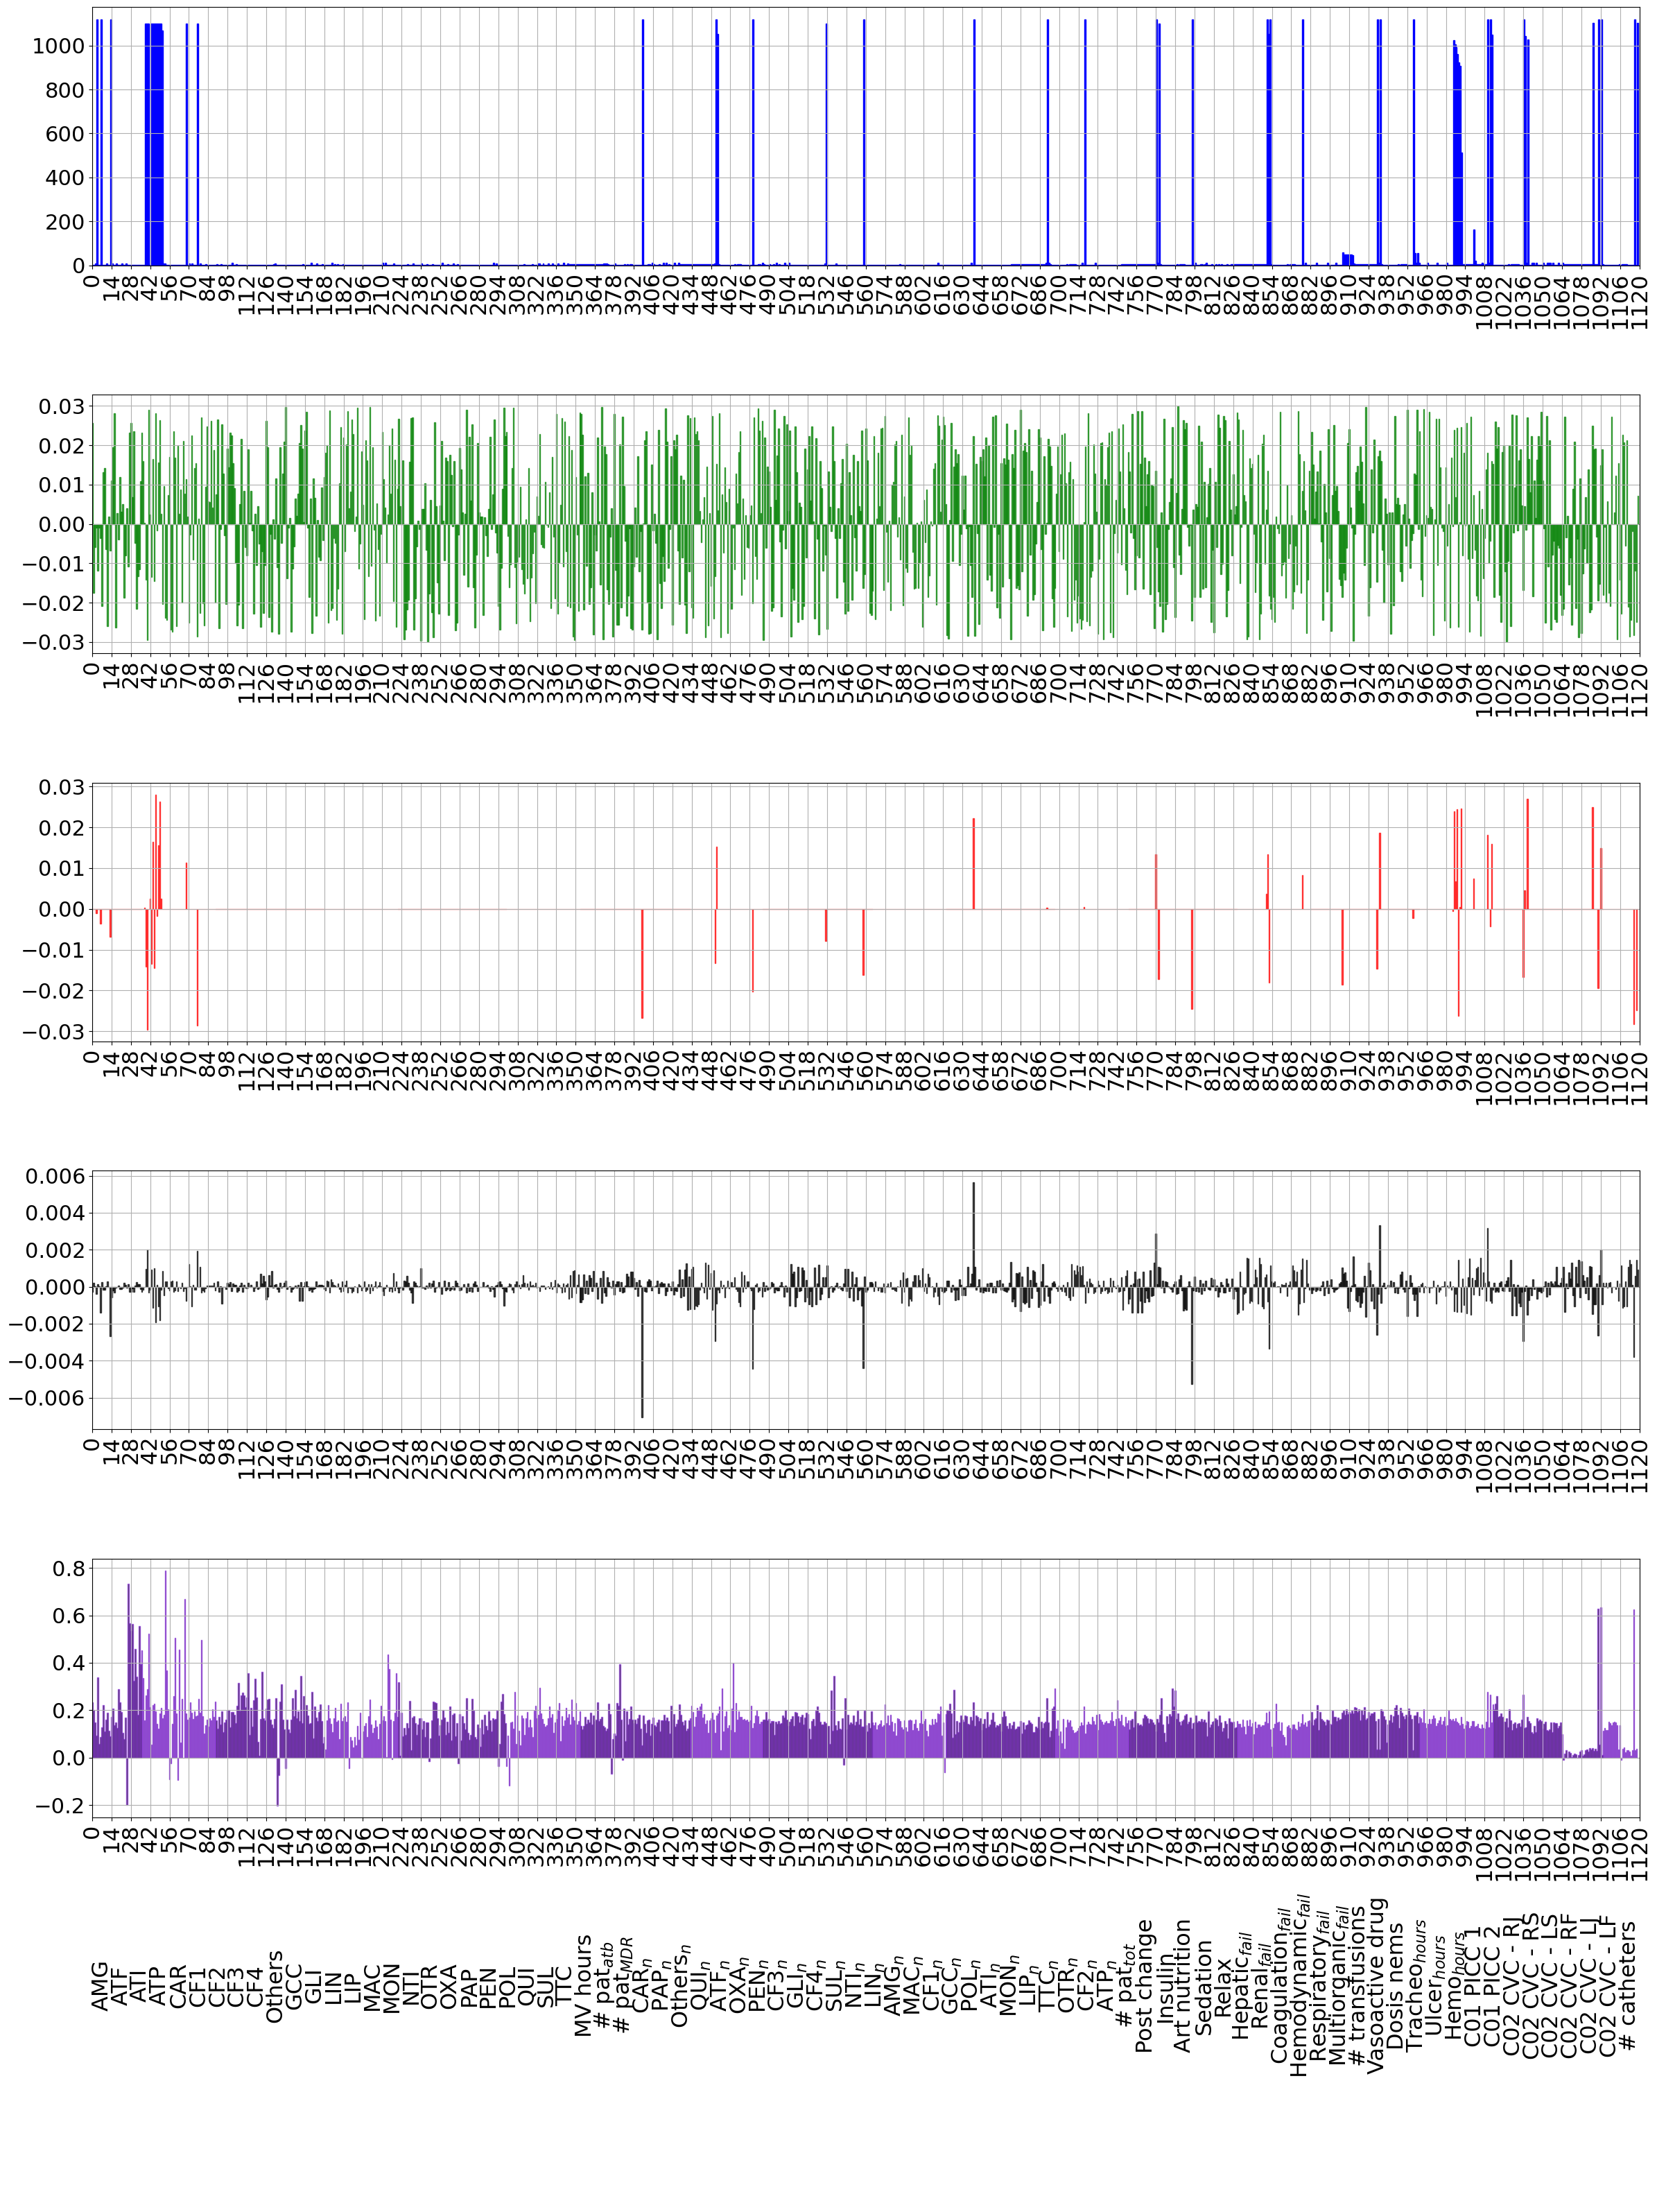

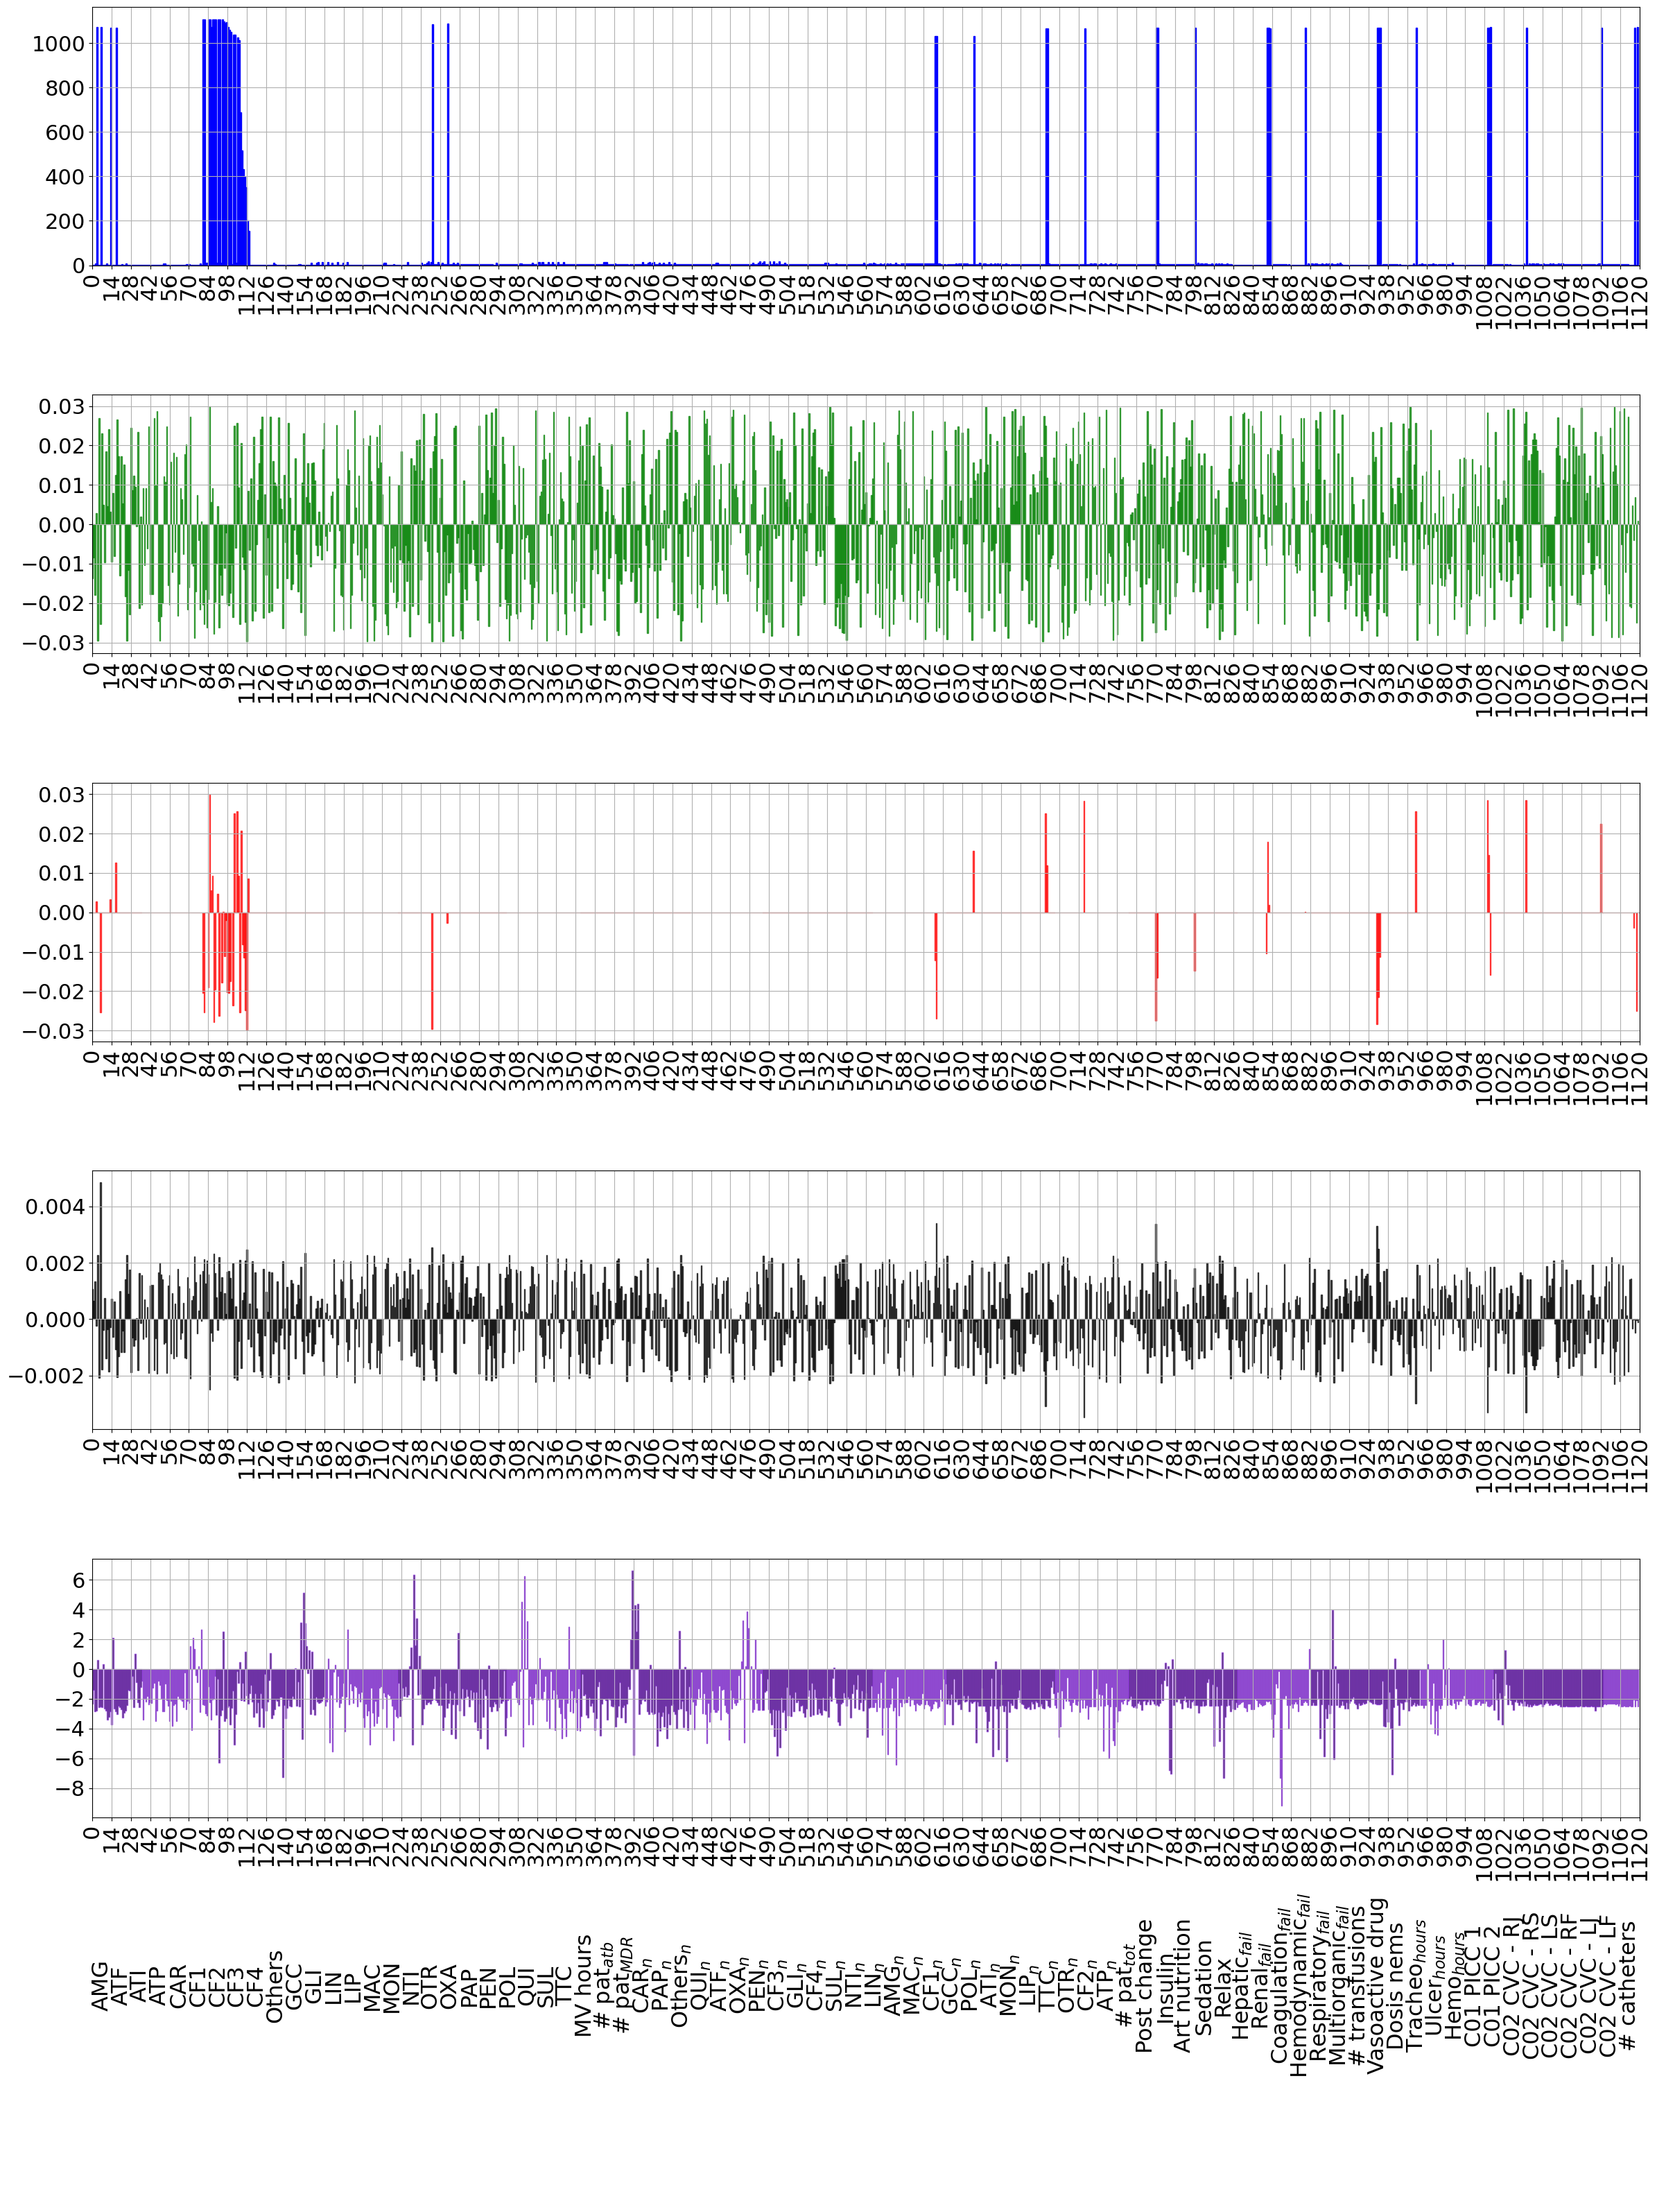

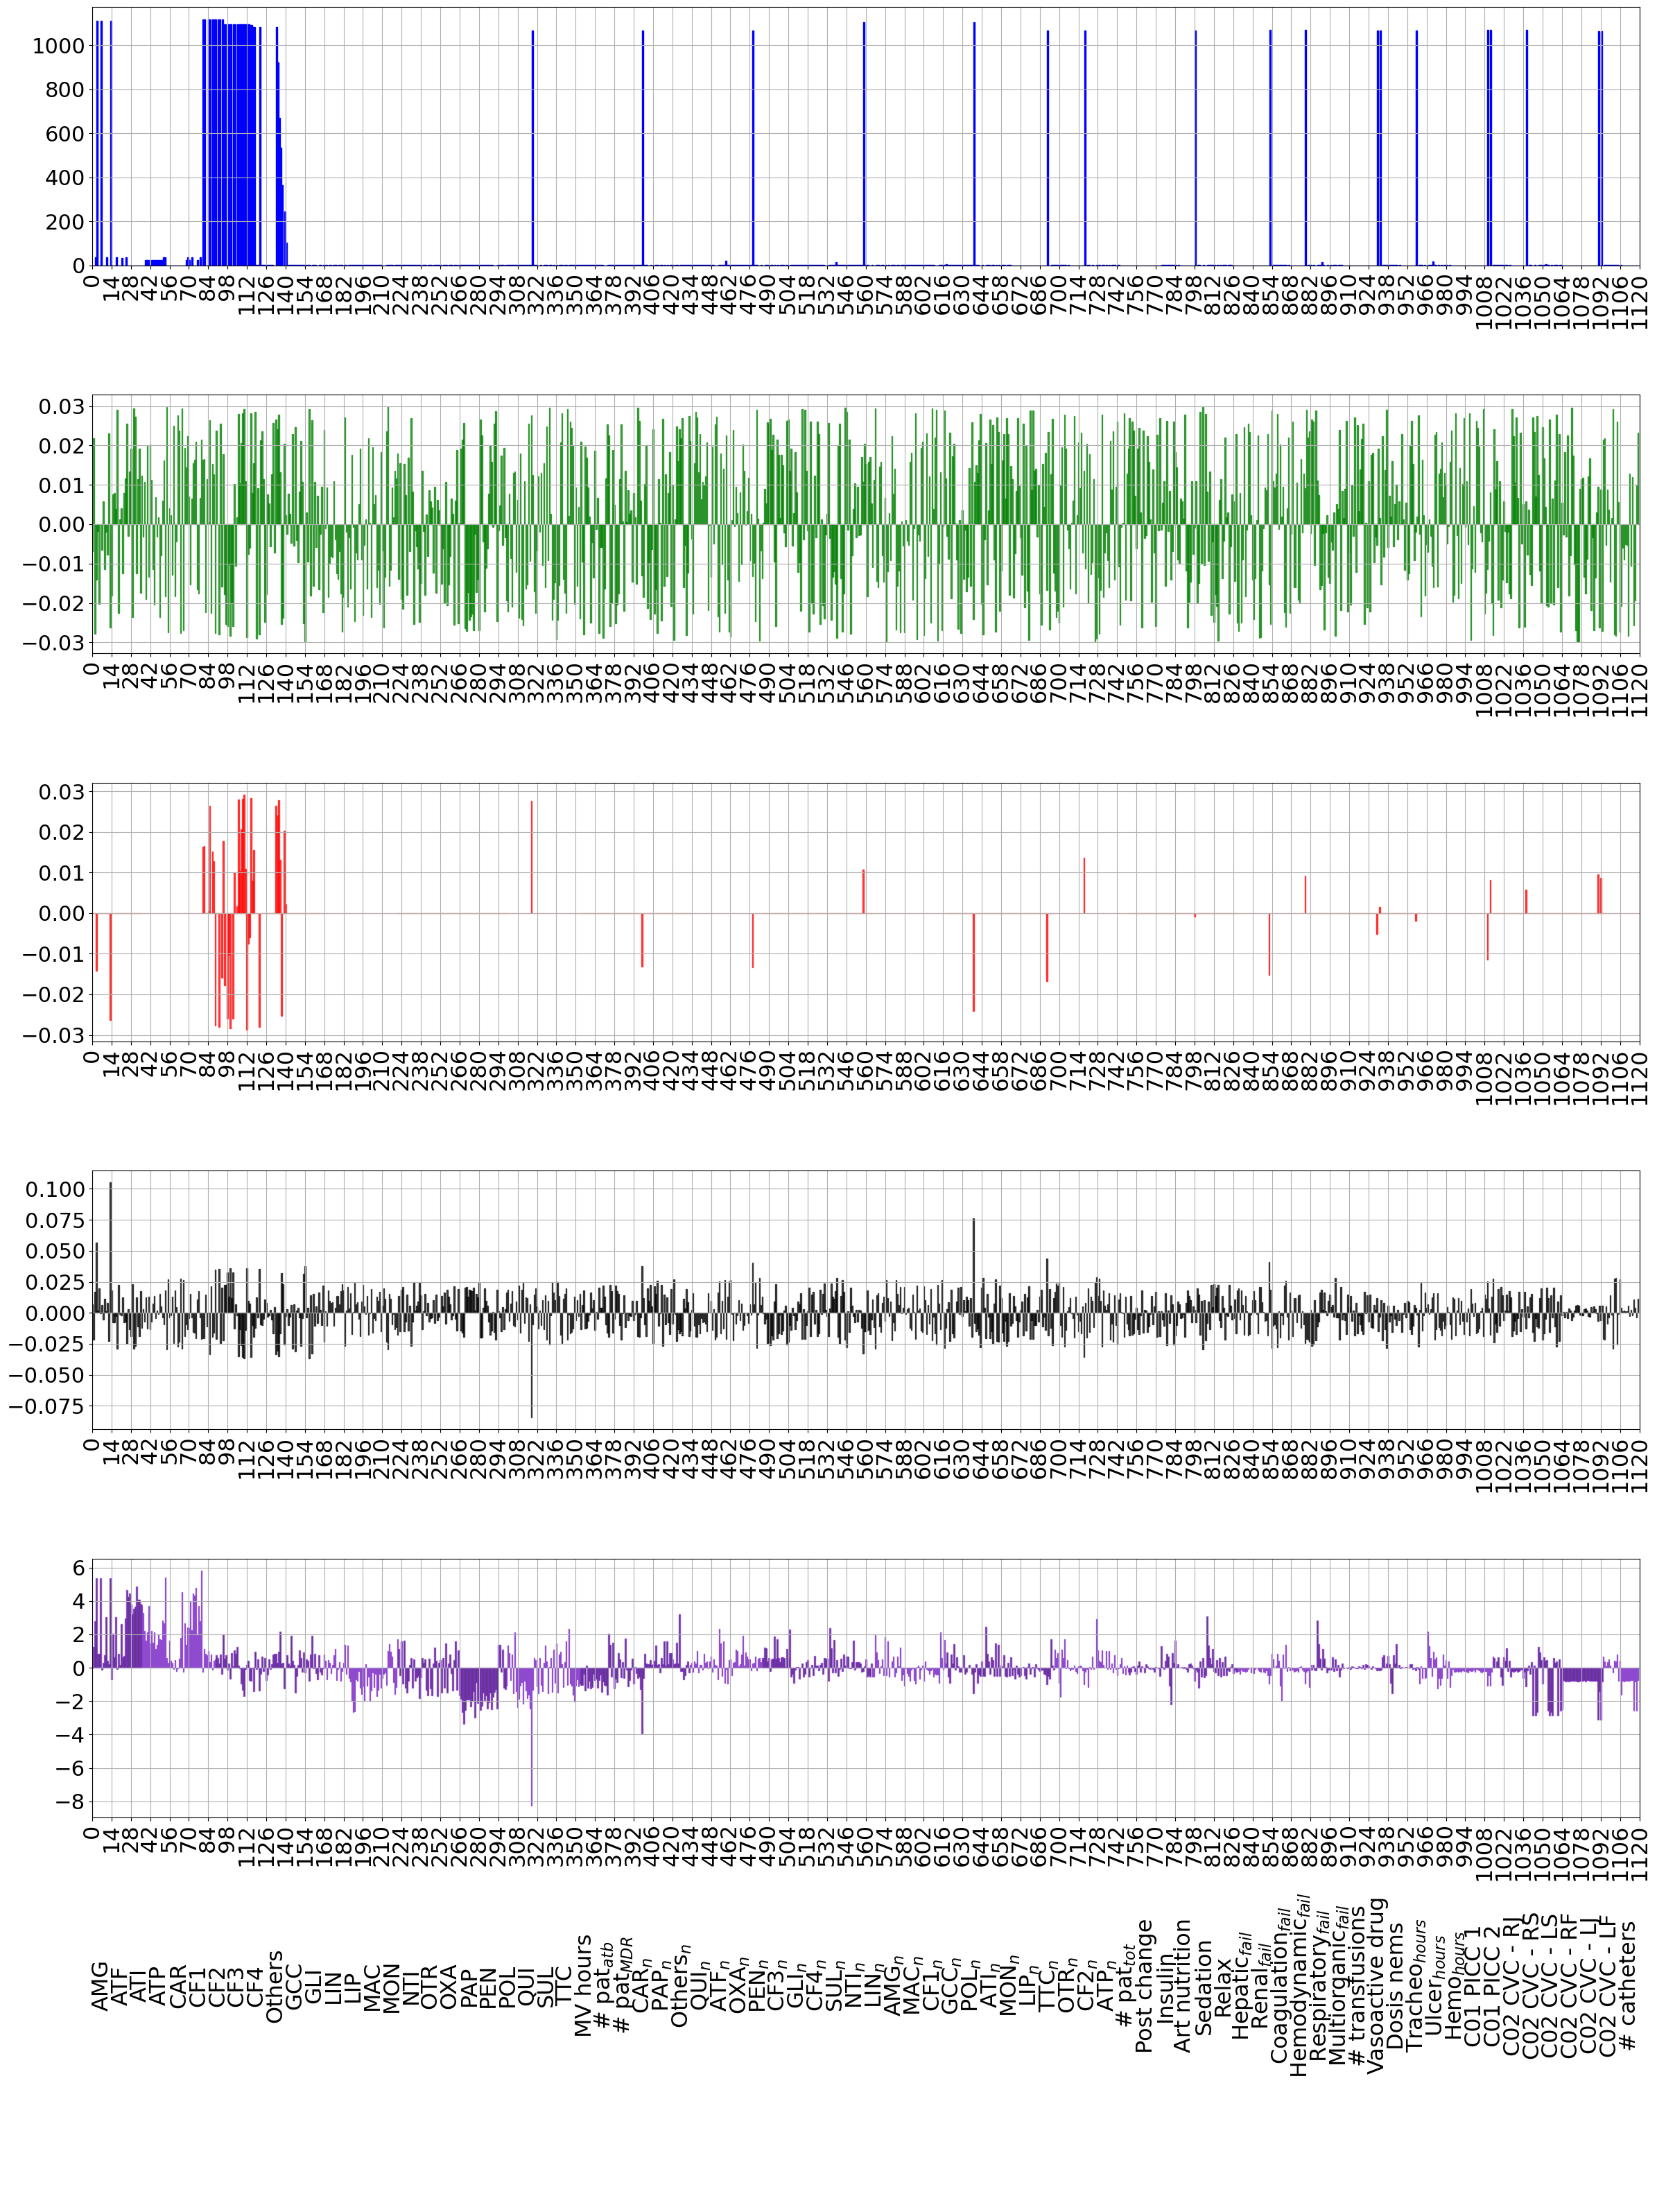

In [26]:
# % percent of total values (1120)
topk_indices_count = 56
colors = ['blue', 'green', 'red', 'Black', 
    'BlueViolet', 'Brown', 'BurlyWood', 'CadetBlue', 'Chartreuse',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson']

for c in range(len(folders)):

    model = gnn_models[folders[c]]
    outputs_importances_pre_fc = []
    outputs_importances_post_fc_pre_sig = []
    outputs_weights_fc = []
    
    idxs_statisc_freq = []
    
    for n in range(T*F):
        tensor = torch.zeros(T*F, 1, device=device).T
        tensor[:, n] = 1
        with torch.no_grad():
            tensor = tensor.unsqueeze(2) 
            pred_probs, importances_pre_fc, weights_fc, importances_post_fc_pre_sig, filters = model(tensor)
            
            # Process importances and weights
            valores = importances_pre_fc[0,:,0].cpu().tolist()
            outputs_importances_pre_fc.append(valores[n])
            
            valores_post_fc = importances_post_fc_pre_sig[0].cpu().tolist()[0]
            outputs_importances_post_fc_pre_sig.append(valores_post_fc)
            
            valores_weights = weights_fc[0,:].cpu().tolist()
            outputs_weights_fc.append(valores_weights[n])

            # Obtain the indices of the X largest values in the second dimension.
            _, topk_indices = torch.topk(importances_pre_fc.squeeze().abs(), k=topk_indices_count)
            idxs_statisc_freq.extend(topk_indices.tolist())
            
    dim = T*F
    
    
    # Filter indices based on frequency threshold
    if topk_indices_count != 0:
        cont = Counter(idxs_statisc_freq)
        values = [valor for valor, cuenta in cont.items() if cuenta > topk_indices_count]
        idxs_uniq = sorted(set(values))
    else:
        idxs_uniq = sorted(set(idxs_statisc_freq))

    weights_values = [outputs_weights_fc[i] if i in idxs_uniq else 0 for i in range(len(outputs_weights_fc))]
    
    
    # computing the value of w⊤ * h(L) in (15)
    w = torch.tensor(outputs_weights_fc).to('cpu')
    h = importances_pre_fc.squeeze().to('cpu')
    h_w_values = w*h
    h_w_values = h_w_values.numpy()

    # Plotting
    plt.figure(figsize=(24, 32))

    plt.subplot(6, 1, 1)
    plt.hist(idxs_statisc_freq, bins=range(T*F), edgecolor=colors[0], color=colors[0])
    plt.grid(True)
    plt.xticks(range(0, T*F+T, T), rotation=90, fontsize=23)
    plt.yticks(fontsize=22)
    plt.xlim(0, T*F)

    plt.subplot(6, 1, 2)
    plt.bar(range(len(outputs_weights_fc)), outputs_weights_fc, edgecolor=colors[1], alpha=0.7, color=colors[1])
    plt.grid(True)
    plt.xticks(range(0, T*F+T, T), rotation=90, fontsize=23)
    plt.yticks(fontsize=22)
    plt.xlim(0, len(outputs_weights_fc))

    plt.subplot(6, 1, 3)
    plt.bar(range(len(weights_values)), weights_values, edgecolor=colors[2], alpha=0.7, color=colors[2])
    plt.grid(True)
    plt.xticks(range(0, T*F+T, T), rotation=90, fontsize=23)
    plt.yticks(fontsize=22)
    plt.xlim(0, len(weights_values))
    
    plt.subplot(6, 1, 4)
    plt.bar(range(len(h_w_values)), h_w_values, edgecolor=colors[3], alpha=0.7, color=colors[3])
    plt.grid(True)
    plt.xticks(range(0, T*F+T, T), rotation=90, fontsize=23)
    plt.yticks(fontsize=22)
    plt.xlim(0, len(h_w_values))

    plt.subplot(6, 1, 5)
    plt.bar(range(len(outputs_importances_post_fc_pre_sig)), outputs_importances_post_fc_pre_sig, edgecolor=colors[4], alpha=0.7, color=colors[3])
    plt.grid(True)
    plt.xticks(range(0, T*F+T, T), rotation=90, fontsize=23)
    plt.yticks(fontsize=22)
    plt.xlim(0, len(outputs_importances_post_fc_pre_sig))

    # Create an empty subplot for text
    ax = plt.subplot(6, 1, 6)
    ax.set_xlim(0, T*F)
    ax.set_ylim(0, 1)  # Set limits to ensure the text is placed correctly
    ax.axis('off')  # Hide the axis

    # Calculate appropriate x positions for text based on the number of features
    x_positions = np.linspace(0, T*F, len(all_keys) + 1)[:-1] + T / 2

    for i, (x, feature_name) in enumerate(zip(x_positions, all_keys)):
        ax.text(x, 0.85, feature_name, ha='center', va='center', rotation=90, fontsize=23)

    plt.tight_layout()

#     Save the figure as a PDF without margins
    plt.savefig(f"../Interpretability/"+way_to_build_graph+"/E5STG_"+folders[c]+".pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

## B.1. Statistical frequency analysis

In [27]:
# Generate node names
node_names = ex.nodeNames()
# Count occurrences of indices
occurrences = ex.countIndexOccurrences(idxs_statisc_freq)
# Get important nodes based on the counted indices
important_nodes = ex.getValues(node_names, list(occurrences.keys()))
# Split node names into variable and time step
result = ex.splitListElements(important_nodes)
# Create a table using the results
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,X,X,X,X,X,X,X,-,-,-,-,-,-
# pat$_{MDR}$,-,X,X,X,X,X,X,X,-,-,-,-,-,-
# pat$_{atb}$,-,X,X,X,X,X,X,X,-,-,-,-,-,-
# pat$_{tot}$,-,X,X,X,X,X,X,X,-,-,-,-,-,-
# transfusions,-,X,X,X,X,X,X,X,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,X,-,-,-,-,-,-,-,X,-,X,X,-,-
TTC$_{n}$,X,X,X,X,X,X,X,X,-,-,-,-,-,-
Tracheo$_{hours}$,X,X,X,X,X,X,X,X,-,-,-,-,-,-
Ulcer$_{hours}$,X,X,X,X,X,X,X,X,-,-,-,-,-,-


In [28]:
# Count the occurrences of each index in `idxs_statisc_freq`
occurrences = ex.countIndexOccurrences(idxs_statisc_freq)
# Filter occurrences based on a threshold
filter_occur = ex.filterKeysByThreshold(occurrences, 56)
# Retrieve the important nodes based on filtered occurrences
important_nodes = ex.getValues(node_names, filter_occur)
# Split the important node names into variable and time step
result = ex.splitListElements(important_nodes)
# Create a table using the results with "X" for presence
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# pat$_{MDR}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
AMG,-,X,-,-,-,-,-,-,-,-,-,-,-,-
AMG$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP,X,-,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,X,X,X
Art nutrition,-,X,-,-,-,-,-,-,-,-,-,-,-,-


## B.2. We combine the statistical frequency with the weights of the FC layer

In [29]:
idxs_mdr = [i for i, value in enumerate(weights_values) if value > 0]
important_nodes = ex.getValues(node_names, idxs_mdr)
# Split node names into variable and time step
result = ex.splitListElements(important_nodes)
# Create a table using the results
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# pat$_{MDR}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
AMG,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,-,X,X,X
Art nutrition,-,X,-,-,-,-,-,-,-,-,-,-,-,-
C02 CVC - LF,-,-,-,X,-,-,X,-,X,-,X,-,X,-
CAR,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CAR$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-


In [30]:
idxs_nonmdr = [i for i, value in enumerate(weights_values) if value < 0]
important_nodes = ex.getValues(node_names, idxs_nonmdr)
# Split node names into variable and time step
result = ex.splitListElements(important_nodes)
# Create a table using the results
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12
AMG$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-
ATF$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-
ATP,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,-,-
C02 CVC - LF,-,-,-,-,X,X,-,X,-,X,-,X,-
CF2$_{n}$,-,-,-,-,-,-,-,-,X,-,-,-,-
GLI,-,X,-,-,-,-,-,-,-,-,-,-,-
LIN,-,X,-,-,-,-,-,-,-,-,-,-,-
LIP,X,-,-,-,-,-,-,-,-,-,-,-,-
MAC,-,X,-,-,-,-,-,-,-,-,-,-,-


# B3: computing the value of w⊤ * h(L) in Eq: (15)

## Positive values

In [31]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(h_w_values, 0, np.inf)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,-,-,-,X,X,-,-,X,-,-,-,X,X
# pat$_{MDR}$,-,-,X,-,-,-,X,X,X,-,X,-,-,X
# pat$_{atb}$,X,-,X,-,-,-,-,-,-,-,-,-,X,-
# pat$_{tot}$,X,-,-,X,-,X,-,X,X,-,X,X,X,X
# transfusions,-,-,X,-,X,X,-,-,-,-,-,X,X,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,-,X,X,-,-,-,-,X,X,X,X,X,-,-
TTC$_{n}$,X,X,-,-,X,-,X,-,-,X,-,X,X,-
Tracheo$_{hours}$,-,X,X,-,-,X,-,-,X,-,X,-,-,X
Ulcer$_{hours}$,-,X,-,X,-,-,X,X,-,-,-,-,-,X


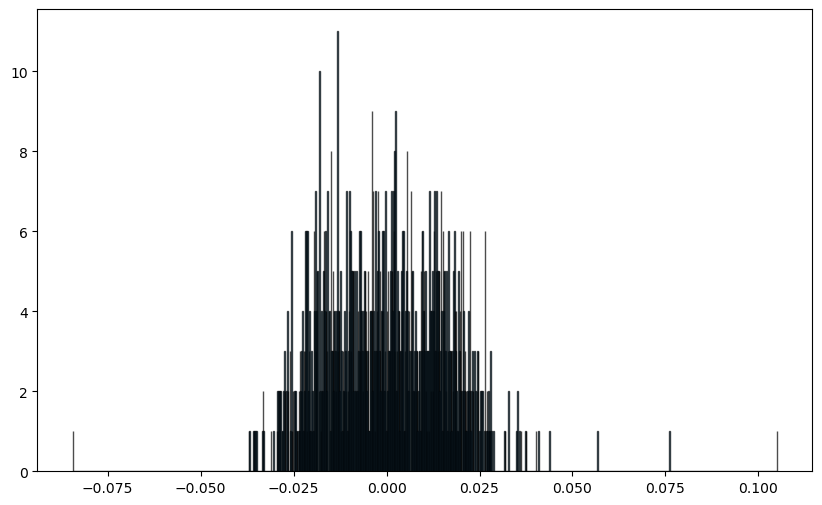

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(h_w_values, bins=1120, edgecolor='black', alpha=0.7)
plt.show()

## 1. Variables close to 0

In [33]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(h_w_values, -0.025, 0.025)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,-,X,X,X,X,X,X,X,X,X,X,X,X
# pat$_{MDR}$,X,X,X,X,X,X,X,X,X,X,X,X,X,X
# pat$_{atb}$,X,-,X,X,X,X,X,X,X,X,X,X,X,X
# pat$_{tot}$,X,-,X,X,X,X,X,X,X,X,X,X,X,X
# transfusions,-,-,X,X,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,X,X,X,X,X,X,X,X,X,X,X,X,X,X
TTC$_{n}$,X,X,X,X,X,X,X,X,X,X,X,X,X,X
Tracheo$_{hours}$,X,X,X,X,X,X,X,X,X,X,X,X,X,X
Ulcer$_{hours}$,X,X,X,X,X,X,X,X,X,X,X,X,X,X


## 2. Variables with high values (greater influence/importance + class)

In [34]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(h_w_values, 0.025, np.inf)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
AMG$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATF$_{n}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
ATP,X,-,-,-,-,-,X,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,-,X,-,-,-
C02 CVC - LF,-,-,-,-,X,X,-,X,-,-,-,-,-,-
C02 CVC - RJ,-,X,-,-,-,-,-,-,-,-,-,-,-,-
C02 CVC - RS,-,X,-,-,-,-,-,-,-,-,-,-,-,-
CF1,-,-,-,-,-,-,-,-,X,-,-,-,-,-
CF2$_{n}$,-,-,-,-,-,-,-,-,X,-,-,-,-,-
CF3,-,-,-,-,-,-,-,-,-,X,-,-,-,-


## 3. Variables with high values (greater influence/importance - class)

In [35]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(h_w_values, -np.inf, -0.025)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{atb}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,-,X,-,-,-,-,-,-,-,-,-,-,-,-
# transfusions,X,X,-,-,-,-,-,-,-,-,-,-,-,-
AMG,-,-,-,-,-,-,-,-,-,-,-,-,X,-
ATF,-,-,-,-,-,-,X,-,-,-,-,-,-,-
ATP,-,-,-,-,-,-,-,-,X,-,-,X,-,-
C01 PICC 1,-,X,X,-,-,-,-,-,-,-,-,-,-,-
C02 CVC - LF,-,-,-,X,-,-,X,-,X,-,-,-,-,-
C02 CVC - LJ,-,X,-,-,-,-,-,-,-,-,-,-,-,-


## B.4. Sensitivity of the architecture

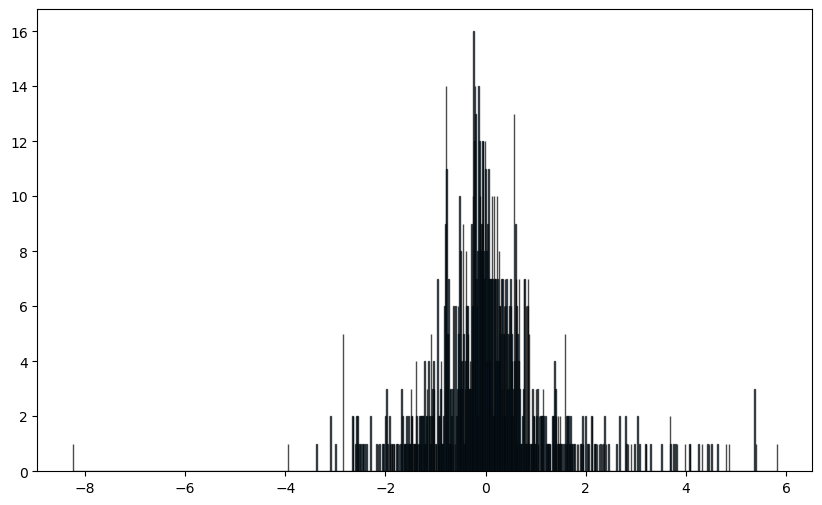

In [36]:
plt.figure(figsize=(10, 6))
plt.hist(outputs_importances_post_fc_pre_sig, bins=1120, edgecolor='black', alpha=0.7)
plt.show()

### Nodes clost to 0 - Pre sigmoid

In [37]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(outputs_importances_post_fc_pre_sig, -0.05, 0.05)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,-,-,-,-,-,-,-,-,-,-,X,-,-
# pat$_{MDR}$,-,X,-,-,-,-,-,-,-,-,-,X,-,-
# transfusions,-,-,-,-,-,-,-,-,X,X,-,X,-,-
AMG,X,-,-,-,-,-,-,-,-,-,-,-,-,-
AMG$_{n}$,-,-,-,-,-,-,-,-,-,X,-,-,-,-
ATI,-,-,-,-,-,-,-,-,-,X,-,-,-,-
ATI$_{n}$,-,-,-,-,-,X,-,-,-,-,-,-,-,-
ATP$_{n}$,-,-,-,-,-,-,-,-,-,X,-,-,-,-
Art nutrition,-,-,-,-,-,-,-,-,-,-,X,X,X,-
C01 PICC 1,-,-,-,-,-,-,-,-,-,X,-,-,-,-


### Nodes above a threshold

In [38]:
th = np.max(np.abs(outputs_importances_post_fc_pre_sig))*0.5
print("Threshold:", th)
indices = ex.getIndexByRange(np.abs(outputs_importances_post_fc_pre_sig), th, np.inf)
importantsNodes = ex.getValues(node_names, indices)
print(len(importantsNodes))
result = ex.splitListElements(importantsNodes)
table = ex.createTableWithSymbols(result)
table

Threshold: 4.122889041900635
14


,0,1,2,3
# catheters,X,-,-,-
# pat$_{MDR}$,X,-,-,-
# pat$_{atb}$,X,-,-,-
# pat$_{tot}$,X,-,-,-
# transfusions,X,-,-,-
ATF$_{n}$,X,-,-,-
ATP,X,-,-,-
C02 CVC - LF,-,-,-,X
C02 CVC - LS,X,-,-,-
C02 CVC - RJ,X,-,-,-


## Nodes over 0

In [39]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(outputs_importances_post_fc_pre_sig, 0, np.inf)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,X,X,X,-,-,X,X,-,-,-,-,X,-,-
# pat$_{MDR}$,X,-,-,-,-,-,-,-,-,X,-,-,-,-
# pat$_{atb}$,X,X,-,-,-,-,-,-,-,-,-,-,-,-
# pat$_{tot}$,X,X,-,-,-,-,-,-,-,-,-,-,-,-
# transfusions,X,X,-,-,-,X,X,-,-,X,-,X,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,X,X,-,-,-,X,X,X,-,X,X,-,-,-
TTC$_{n}$,X,-,-,-,-,-,-,-,-,-,-,-,-,-
Tracheo$_{hours}$,X,-,-,-,-,X,-,-,-,-,-,X,-,-
Ulcer$_{hours}$,X,X,-,-,-,X,-,-,-,X,-,X,-,-


## Nodes under 0

In [40]:
# Retrieve indices of importance scores within the specified range
indices = ex.getIndexByRange(outputs_importances_post_fc_pre_sig, -np.inf, 0)
# Get the node names corresponding to these indices
important_nodes = ex.getValues(node_names, indices)
# Split node names into variable names and time steps
result = ex.splitListElements(important_nodes)
# Create a table to represent the presence of nodes at each time step
table = ex.createTableWithSymbols(result)
table

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
# catheters,-,-,-,X,X,-,-,X,X,X,X,-,X,X
# pat$_{MDR}$,-,X,X,X,X,X,X,X,X,-,X,X,X,X
# pat$_{atb}$,-,-,X,X,X,X,X,X,X,X,X,X,X,X
# pat$_{tot}$,-,-,X,X,X,X,X,X,X,X,X,X,X,X
# transfusions,-,-,X,X,X,-,-,X,X,-,X,-,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTC,-,-,X,X,X,-,-,-,X,-,-,X,X,X
TTC$_{n}$,-,X,X,X,X,X,X,X,X,X,X,X,X,X
Tracheo$_{hours}$,-,X,X,X,X,-,X,X,X,X,X,-,X,X
Ulcer$_{hours}$,-,-,X,X,X,-,X,X,X,-,X,-,X,X
